In [1]:

import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.experimentclasses.RigidEthanolPCA import RigidEthanolPCA
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_cosines
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell

#set parameters
n = 10000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 0.05 #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
natoms = 9
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#run experiment
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

new_MN = True
new_grad = True
savename = 'rigidethanol_110120_alltorsions'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_110120_alltorsions'



/Users/samsonkoelle/manifoldflasso_jmlr


In [22]:
#The true champion

import autograd.numpy as np
from autograd import jacobian
from autograd import elementwise_grad
from autograd import grad

import logging
from copy import deepcopy

#import numpy as np
from scipy.special import expit
from pyglmnet import utils


class GLM:
    
    def __init__(self, xs, ys, reg_lambda, group,max_iter, learning_rate, tol,parameter):
        self.xs = xs
        self.ys = ys
        self.reg_lambda = reg_lambda
        self.group = np.asarray(group)
        #print(self.group.shape)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.Tau = None
        self.alpha = 1.
        self.lossresults = {}
        self.dls = {}
        self.parameter = parameter
        self.l2loss = {}
        self.penalty = {}
        
    def _prox(self,beta, thresh):
        """Proximal operator."""
        
        #print(thresh, beta)
        #print('beginprox', beta[0:2],thresh)
        group_ids = np.unique(self.group)
        result = np.zeros(beta.shape)
        result = np.asarray(result, dtype = float)
        #print('gids',group_ids)
        for i in range(len(group_ids)):
            gid = i 
            #print(self.group)
            idxs_to_update = np.where(self.group == gid)[0]
            #print('idx',idxs_to_update)
            #print('norm', np.linalg.norm(beta[idxs_to_update]))
            if np.linalg.norm(beta[idxs_to_update]) > 0.:
                #print('in here', len(idxs_to_update))
                potentialoutput = beta[idxs_to_update] - (thresh / np.linalg.norm(beta[idxs_to_update])) * beta[idxs_to_update]
                posind = np.where(beta[idxs_to_update] > 0.)[0]
                negind = np.where(beta[idxs_to_update] < 0.)[0]
                po = beta[idxs_to_update].copy()
                #print('potention', potentialoutput[0:2])
                po[posind] = np.asarray(np.clip(potentialoutput[posind],a_min = 0., a_max = 1e15), dtype = float)
                po[negind] = np.asarray(np.clip(potentialoutput[negind],a_min = -1e15, a_max = 0.), dtype = float)
                result[idxs_to_update] = po
        #print('end', result[0:2])
        return result

    def _grad_L2loss(self, beta, X, y):
        #print(beta.shape,X.shape,y.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        n_samples = np.float(X.shape[0])
        z = np.dot(X, beta)
        #grad_beta = 1. / n_samples * np.transpose(np.dot(np.transpose(z - y), X))
        grad_beta = np.transpose(np.dot(np.transpose(z - y), X))
        #print('gb',grad_beta.shape)
        return grad_beta
    
    def _loss(self,beta, reg_lambda, X, y):
        """Define the objective function for elastic net."""
        L = self._logL(beta, X, y)
        P = self._L1penalty(beta)
        J = -L + reg_lambda * P
        return J
    
    def _logL(self,beta, X, y):
        """The log likelihood."""
        #print('beginlogL', np.linalg.norm(beta), np.linalg.norm(X), np.linalg.norm(y),y.shape,beta.shape,X.shape,)
        l = np.dot(X, beta)
        logL = -0.5 * np.sum((y - l)**2)
        #print('endlogL',logL)
        return logL
    
    def _L2loss(self,beta,X,y):
        #print('beginl2', np.linalg.norm(beta), np.linalg.norm(X), np.linalg.norm(y), y.shape)
        output = -self._logL(beta, X, y)
        #print('outl2',output)
        return(output)
    
    def _L1penalty(self, beta):
        """The L1 penalty"""
        # Compute the L1 penalty
        group = self.group
        group_ids = np.unique(self.group)
        L1penalty = 0.0
        for group_id in group_ids:
            L1penalty += np.linalg.norm(beta[self.group == group_id], 2)
        return L1penalty
    
    #def fhatlambda(self,lamb,x,y):
    def fhatlambda(self,lamb,betanew,betaold):
        xs = self.xs
        ys = self.ys
        #print(ys.shape,'fhatlam')
        #print(self._L2loss(betaold,xs,ys),self._L2loss(betanew,xs,ys),'old','new') 
        output = self._L2loss(betaold,xs,ys) + np.dot(self._grad_L2loss(betaold,xs,ys).transpose(),(betanew-betaold)) + (1/(2*lamb)) * np.linalg.norm(betanew-betaold)**2
        return(output)
    
    #_btalgorithm(yk,lamb,.5,1000, rl)
    def _btalgorithm(self,bet,lam,b,maxx,rl):
        
        #print('lam',lam)
        X = self.xs
        y = self.ys
        #print('beginbt', np.linalg.norm(y))
        #print('beginbt',self._L2loss(bet,X,y))
        #print(np.linalg.norm(bet))
        grad_beta = self._grad_L2loss(beta = bet, X = X, y = y)
        for i in range(maxx):
            #print('bt',i)
            betn = bet - lam * grad_beta
            z = self._prox(betn, lam * rl)
            fz = self._L2loss(z,X,y)
            #print(fz,'fz')
            fhatz = self.fhatlambda(lam,z, bet)
            if fz <= fhatz:
                print(i,'btiterstop')
            #print(fhatz - fz)
            #if 0 <= 1:
                break
            lam = b*lam
        return(z,lam)
    
    def fit(self):
        

        group  = self.group
        print(group.shape)
        lambdas = self.reg_lambda
        parameter = self.parameter
        X = self.xs
        #print(X.shape)
        y = self.ys
        
        np.random.RandomState(0)
        group = np.asarray(group, dtype = np.int64)

        #print(group.shape[0])
        group.dtype = np.int64
        #print(group.shape[0])
        #print(X.shape[1])
        if group.shape[0] != X.shape[1]:
            raise ValueError('group should be (n_features,)')

        # type check for data matrix
        if not isinstance(X, np.ndarray):
            raise ValueError('Input data should be of type ndarray (got %s).'
                             % type(X))

        n_features = np.float(X.shape[1])
        n_features = np.int64(n_features)
        if y.ndim == 1:
            y = y[:, np.newaxis]
            self.ys = y
        #print(y.shape)
        n_classes = 1
        n_classes = np.int64(n_classes)

        beta_hat = 1 / (n_features) * np.random.normal(0.0, 1.0, [n_features, n_classes])
        fit_params = list()
        
        for l, rl in enumerate(lambdas):
            fit_params.append({'beta': beta_hat})
            if l == 0:
                fit_params[-1]['beta'] = beta_hat
            else:
                fit_params[-1]['beta'] = fit_params[-2]['beta']
            tol = self.tol
            alpha = 1.
            beta = np.zeros([n_features, n_classes])
            beta = fit_params[-1]['beta']
            #print('losser',self._L2loss(beta,X,y))
            g = np.zeros([n_features, n_classes])
            L, DL ,L2,PEN = list(), list() , list(), list()
            lamb = self.learning_rate
            bm1 = beta.copy()
            bm2 = beta.copy()
            for t in range(0, self.max_iter):
                L.append(self._loss(beta, rl, X, y))
                L2.append(self._L2loss(beta,X,y))
                PEN.append(self._L1penalty(beta))
                w = (t / (t+ 3))
                yk = beta + w*(bm1 - bm2)
                #print('losser',self._L2loss(yk,X,y))
                #print('beforebt',np.linalg.norm(yk),np.linalg.norm(X),np.linalg.norm(y))
                beta , lamb = self._btalgorithm(yk,lamb,.5,1000, rl)
                #X = self.xs
                #y = self.ys
                #print('losser2',self._L2loss(beta,X,y))
                bm2 = bm1.copy()
                bm1 = beta.copy()
                if t > 1:
                    DL.append(L[-1] - L[-2])
                    if np.abs(DL[-1] / L[-1]) < tol:
                        print('converged', rl)
                        msg = ('\tConverged. Loss function:'
                               ' {0:.2f}').format(L[-1])
                        msg = ('\tdL/L: {0:.6f}\n'.format(DL[-1] / L[-1]))
                        break
                    
            #print(beta)
            fit_params[-1]['beta'] = beta
            self.lossresults[rl] = L
            self.l2loss[rl] = L2
            self.penalty[rl] = PEN
            self.dls[rl] = DL
            #print(L)
        # Update the estimated variables
        
        self.fit_ = fit_params
        self.ynull_ = np.mean(y)

        # Return
        return self
 
#The true champion

# import sys
# !{sys.executable} -m pip install einops
from einops import rearrange

import autograd.numpy as np
from autograd import jacobian
from autograd import elementwise_grad
from autograd import grad

import logging
from copy import deepcopy

#import numpy as np
from scipy.special import expit
from pyglmnet import utils


class GradientGroupLasso:
    
    def __init__(self, dg_M, df_M, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None):
        
        n = dg_M.shape[0]
        d= dg_M.shape[1]
        m = df_M.shape[2]
        p = dg_M.shape[2]
        dummy_beta = np.ones((n,p,m))
        
        self.dg_M = dg_M
        self.df_M = df_M
        self.reg_l1s = reg_l1s
        self.reg_l2 = reg_l2
        self.beta0_npm = beta0_npm
        self.n = n
        self.p = p
        self.m = m 
        self.d = d
        self.dummy_beta = dummy_beta
        #self.group = np.asarray(group)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.Tau = None
        self.alpha = 1.
        self.lossresults = {}
        self.dls = {}
        self.l2loss = {}
        self.penalty = {}
        
    def _prox(self,beta_npm, thresh):
        """Proximal operator."""
        
        p = self.p
        result = np.zeros(beta_npm.shape)
        result = np.asarray(result, dtype = float)
        for j in range(p):
            if np.linalg.norm(beta_npm[:,j,:]) > 0.:
                potentialoutput = beta_npm[:,j,:] - (thresh / np.linalg.norm(beta_npm[:,j,:])) * beta_npm[:,j,:]
                posind = np.asarray(np.where(beta_npm[:,j,:] > 0.))
                negind = np.asarray(np.where(beta_npm[:,j,:] < 0.))
                po = beta_npm[:,j,:].copy()
                po[posind[0],posind[1]] = np.asarray(np.clip(potentialoutput[posind[0],posind[1]],a_min = 0., a_max = 1e15), dtype = float)
                po[negind[0],negind[1]] = np.asarray(np.clip(potentialoutput[negind[0],negind[1]],a_min = -1e15, a_max = 0.), dtype = float)
                result[:,j,:] = po
        return result

    def _grad_L2loss(self, beta_npm):
        
        df_M = self.df_M
        dg_M = self.dg_M
        reg_l2 = self.reg_l2
        dummy_beta = self.dummy_beta
        
        df_M_hat = np.einsum('ndp,npm->ndm',dg_M, beta_npm)
        error = df_M_hat - df_M
        grad_beta = np.einsum('ndm,ndp->npm',error,dg_M) #+ reg_l2 * np.ones()
        #if 
        return grad_beta
    
    def _L1penalty(self, beta_npm):
        
        p = self.p
        m = self.m
        n = self.n 
        beta_mn_p = rearrange(beta_npm, 'n p m -> (m n) p')#np.reshape(beta_mnp, ((m*n,p)))
        L1penalty = np.linalg.norm(beta_mn_p, axis = 0).sum()
        
        return L1penalty
    
    def _loss(self,beta_npm, reg_lambda):
        """Define the objective function for elastic net."""
        L = self._logL(beta_npm)
        P = self._L1penalty(beta_npm)
        J = -L + reg_lambda * P
        return J
    
    def _logL(self,beta_npm):
        
        df_M = self.df_M
        dg_M = self.dg_M
        
        df_M_hat = np.einsum('ndp,npm -> ndm',dg_M, beta_npm)
        logL = -0.5 * np.linalg.norm((df_M - df_M_hat))**2
        return(logL)
    
    def _L2loss(self,beta_npm):
        output = -self._logL(beta_npm)
        return(output)

    def fhatlambda(self,learning_rate,beta_npm_new,beta_npm_old):

        output = self._L2loss(beta_npm_old) + np.einsum('npm,npm', self._grad_L2loss(beta_npm_old),(beta_npm_new-beta_npm_old)) + (1/(2*learning_rate)) * np.linalg.norm(beta_npm_new-beta_npm_old)**2
        
        return(output)

    def _btalgorithm(self,beta_npm ,learning_rate,b,maxiter_bt,rl):
        
        grad_beta = self._grad_L2loss(beta_npm = beta_npm)
        for i in range(maxiter_bt):
            beta_npm_postgrad = beta_npm - learning_rate * grad_beta
            beta_npm_postgrad_postprox = self._prox(beta_npm_postgrad, learning_rate * rl)
            fz = self._L2loss(beta_npm_postgrad_postprox)
            #fhatz = self.fhatlambda(lam,beta_npm_postgrad_postprox, beta_npm_postgrad)
            fhatz = self.fhatlambda(learning_rate,beta_npm_postgrad_postprox, beta_npm)
            if fz <= fhatz:
                print(i, learning_rate)
                break
            learning_rate = b*learning_rate    
            
        return(beta_npm_postgrad_postprox,learning_rate)
    
    def fit(self, beta0_npm = None):

        reg_l1s = self.reg_l1s
        n = self.n
        m = self.m
        p = self.p
        
        dg_M = self.dg_M
        df_M = self.df_M
        
        tol = self.tol
        np.random.RandomState(0)
        
        if beta0_npm is None:
            beta_npm_hat = 1 / (n*m*p) * np.random.normal(0.0, 1.0, [n, p,m])
            #1 / (n_features) * np.random.normal(0.0, 1.0, [n_features, n_classes])
        else: 
            beta_npm_hat = beta0_npm
            
        fit_params = list()
        for l, rl in enumerate(reg_l1s):
            fit_params.append({'beta': beta_npm_hat})
            if l == 0:
                fit_params[-1]['beta'] = beta_npm_hat
            else:
                fit_params[-1]['beta'] = fit_params[-2]['beta']
            
            alpha = 1.
            beta_npm_hat = fit_params[-1]['beta']
            #g = np.zeros([n_features, n_classes])
            L, DL ,L2,PEN = list(), list() , list(), list()
            learning_rate = self.learning_rate
            beta_npm_hat_1 = beta_npm_hat.copy()
            beta_npm_hat_2 = beta_npm_hat.copy()
            for t in range(0, self.max_iter):
                #print(t,l,rl)
                print(t)
                L.append(self._loss(beta_npm_hat, rl))
                L2.append(self._L2loss(beta_npm_hat))
                PEN.append(self._L1penalty(beta_npm_hat))
                w = (t / (t+ 3))
                beta_npm_hat_momentumguess = beta_npm_hat + w*(beta_npm_hat_1 - beta_npm_hat_2)
                
                beta_npm_hat , learning_rate = self._btalgorithm(beta_npm_hat_momentumguess,learning_rate,.5,1000, rl)
                #print(beta_npm_hat_momentumguess.max(), beta_npm_hat.max(),self._L2loss(beta_npm_hat), learning_rate)
                beta_npm_hat_2 = beta_npm_hat_1.copy()
                beta_npm_hat_1 = beta_npm_hat.copy()
                
                if t > 1:
                    DL.append(L[-1] - L[-2])
                    if np.abs(DL[-1] / L[-1]) < tol:
                        print('converged', rl)
                        msg = ('\tConverged. Loss function:'
                               ' {0:.2f}').format(L[-1])
                        msg = ('\tdL/L: {0:.6f}\n'.format(DL[-1] / L[-1]))
                        break

            fit_params[-1]['beta'] = beta_npm_hat
            self.lossresults[rl] = L
            self.l2loss[rl] = L2
            self.penalty[rl] = PEN
            self.dls[rl] = DL

        self.fit_ = fit_params
        #self.ynull_ = np.mean(y)

        return self
    
def get_sr_lambda_sam(dg_M, df_M, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate):
    
    highprobes = np.asarray([])
    lowprobes = np.asarray([])
    #lambdas_start = np.asarray([0,1])
    probe_init_low = lambdas_start[0]
    probe_init_high = lambdas_start[1]

    coeffs = {}
    combined_norms = {}

    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe_init_low]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= None)
    GGL.fit()
    beta0_npm = GGL.fit_[-1]['beta']
    coeffs[probe_init_low] = GGL.fit_[-1]['beta']
    combined_norms[probe_init_low] = np.sqrt((np.linalg.norm(coeffs[probe_init_low], axis = 0)**2).sum(axis = 1))

    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe_init_high]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= beta0_npm)
    GGL.fit(beta0_npm = beta0_npm)
    #beta0_npm = GGL.fit_[-1]['beta']
    coeffs[probe_init_high] = GGL.fit_[-1]['beta']
    combined_norms[probe_init_high] = np.sqrt((np.linalg.norm(coeffs[probe_init_high], axis = 0)**2).sum(axis = 1))

    n_comp = len(np.where(combined_norms[probe_init_high] != 0)[0])
    lowprobes = np.append(lowprobes, probe_init_low)

    if n_comp == card:
        #high_int = probe
        print('we did it')
        return (probe_init_high, coeffs, combined_norms)

    if n_comp < card:
        highprobes = np.append(highprobes, probe_init_high)
        probe = (lowprobes.max() + highprobes.min()) / 2
    if n_comp > card:
        lowprobes = np.append(lowprobes, probe_init_high)
        probe = lowprobes.max() * 2

    for i in range(max_search):
        print(i, probe, 'probe')
        beta0_npm = coeffs[lowprobes.max()]
        if not np.isin(probe, list(combined_norms.keys())):
            #print('probe',probe)
            GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm = beta0_npm)
            GGL.fit(beta0_npm = beta0_npm)
            coeffs[probe] = GGL.fit_[-1]['beta']
            combined_norms[probe] = np.sqrt((np.linalg.norm(coeffs[probe], axis = 0)**2).sum(axis = 1))

        n_comp = len(np.where(combined_norms[probe] != 0)[0])
        if n_comp == card:
            #high_int = probe
            print('we did it')
            return (probe, coeffs, combined_norms)
        else:
            if n_comp < card:
                highprobes = np.append(highprobes, probe)
            if n_comp > card:
                lowprobes = np.append(lowprobes, probe)
            if len(highprobes) > 0:
                probe = (lowprobes.max() + highprobes.min()) / 2
            else:
                probe = lowprobes.max() * 2

                
    #return (probe, coeffs, combined_norms)

In [4]:
with open(workingdirectory + '/untracked_data/embeddings/re_test_exp.pkl' ,
         'rb') as file:
     experiment = pickle.load(file)


In [7]:
nreps = 1
atoms4,p = get_all_atoms_4(natoms)
experiment.p = p
experiment.atoms4 = atoms4
experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = 5
#experiment.folder = folder
nsel = 5
replicates = {}
selected_points_save = np.zeros((nreps,nsel))
for i in range(1):
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    #= experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, lambdas, len(selected_points), n_embedding_coordinates, itermax, tol)


Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwar

In [8]:
replicate = replicates[0]
dg_M = np.swapaxes(replicate.dg_M,1,2)
df_M = replicate.df_M
gl_itermax = 5000
lambdas_start = [0.,.1]
max_search = 15
reg_l2 = 0.
card = 2
tol = 1e-14
learning_rate = .1

In [11]:
probefast, coeffsfast, combined_normsfast = get_sr_lambda_sam(dg_M, df_M, gl_itermax, lambdas_start, reg_l2,max_search, card, tol,1000)

0
15 0.030517578125
1
0 0.030517578125
2
0 0.030517578125
3
0 0.030517578125
4
0 0.030517578125
5
0 0.030517578125
6
0 0.030517578125
7
0 0.030517578125
8
0 0.030517578125
9
0 0.030517578125
10
0 0.030517578125
11
0 0.030517578125
12
0 0.030517578125
13
0 0.030517578125
14
0 0.030517578125
15
0 0.030517578125
16
0 0.030517578125
17
0 0.030517578125
18
0 0.030517578125
19
0 0.030517578125
20
0 0.030517578125
21
0 0.030517578125
22
0 0.030517578125
23
0 0.030517578125
24
0 0.030517578125
25
0 0.030517578125
26
0 0.030517578125
27
0 0.030517578125
28
0 0.030517578125
29
0 0.030517578125
30
0 0.030517578125
31
0 0.030517578125
32
0 0.030517578125
33
0 0.030517578125
34
0 0.030517578125
35
0 0.030517578125
36
0 0.030517578125
37
0 0.030517578125
38
0 0.030517578125
39
0 0.030517578125
40
0 0.030517578125
41
0 0.030517578125
42
0 0.030517578125
43
0 0.030517578125
44
0 0.030517578125
45
0 0.030517578125
46
0 0.030517578125
47
0 0.030517578125
48
0 0.030517578125
49
0 0.030517578125
50
0 0.03

0 0.030517578125
400
0 0.030517578125
401
0 0.030517578125
402
0 0.030517578125
403
0 0.030517578125
404
0 0.030517578125
405
0 0.030517578125
406
0 0.030517578125
407
0 0.030517578125
408
0 0.030517578125
409
0 0.030517578125
410
0 0.030517578125
411
0 0.030517578125
412
0 0.030517578125
413
0 0.030517578125
414
0 0.030517578125
415
0 0.030517578125
416
0 0.030517578125
417
0 0.030517578125
418
0 0.030517578125
419
0 0.030517578125
420
0 0.030517578125
421
0 0.030517578125
422
0 0.030517578125
423
0 0.030517578125
424
0 0.030517578125
425
0 0.030517578125
426
0 0.030517578125
427
0 0.030517578125
428
0 0.030517578125
429
0 0.030517578125
430
0 0.030517578125
431
0 0.030517578125
432
0 0.030517578125
433
0 0.030517578125
434
0 0.030517578125
435
0 0.030517578125
436
0 0.030517578125
437
0 0.030517578125
438
0 0.030517578125
439
0 0.030517578125
440
0 0.030517578125
441
0 0.030517578125
442
0 0.030517578125
443
0 0.030517578125
444
0 0.030517578125
445
0 0.030517578125
446
0 0.030517578

0 0.030517578125
791
0 0.030517578125
792
0 0.030517578125
793
0 0.030517578125
794
0 0.030517578125
795
0 0.030517578125
796
0 0.030517578125
797
0 0.030517578125
798
0 0.030517578125
799
0 0.030517578125
800
0 0.030517578125
801
0 0.030517578125
802
0 0.030517578125
803
0 0.030517578125
804
0 0.030517578125
805
0 0.030517578125
806
0 0.030517578125
807
0 0.030517578125
808
0 0.030517578125
809
0 0.030517578125
810
0 0.030517578125
811
0 0.030517578125
812
0 0.030517578125
813
0 0.030517578125
814
0 0.030517578125
815
0 0.030517578125
816
0 0.030517578125
817
0 0.030517578125
818
0 0.030517578125
819
0 0.030517578125
820
0 0.030517578125
821
0 0.030517578125
822
0 0.030517578125
823
0 0.030517578125
824
0 0.030517578125
825
0 0.030517578125
826
0 0.030517578125
827
0 0.030517578125
828
0 0.030517578125
829
0 0.030517578125
830
0 0.030517578125
831
0 0.030517578125
832
0 0.030517578125
833
0 0.030517578125
834
0 0.030517578125
835
0 0.030517578125
836
0 0.030517578125
837
0 0.030517578

0 0.030517578125
1175
0 0.030517578125
1176
0 0.030517578125
1177
0 0.030517578125
1178
0 0.030517578125
1179
0 0.030517578125
1180
0 0.030517578125
1181
0 0.030517578125
1182
0 0.030517578125
1183
0 0.030517578125
1184
0 0.030517578125
1185
0 0.030517578125
1186
0 0.030517578125
1187
0 0.030517578125
1188
0 0.030517578125
1189
0 0.030517578125
1190
0 0.030517578125
1191
0 0.030517578125
1192
0 0.030517578125
1193
0 0.030517578125
1194
0 0.030517578125
1195
0 0.030517578125
1196
0 0.030517578125
1197
0 0.030517578125
1198
0 0.030517578125
1199
0 0.030517578125
1200
0 0.030517578125
1201
0 0.030517578125
1202
0 0.030517578125
1203
0 0.030517578125
1204
0 0.030517578125
1205
0 0.030517578125
1206
0 0.030517578125
1207
0 0.030517578125
1208
0 0.030517578125
1209
0 0.030517578125
1210
0 0.030517578125
1211
0 0.030517578125
1212
0 0.030517578125
1213
0 0.030517578125
1214
0 0.030517578125
1215
0 0.030517578125
1216
0 0.030517578125
1217
0 0.030517578125
1218
0 0.030517578125
1219
0 0.030517

0 0.00762939453125
1536
0 0.00762939453125
1537
0 0.00762939453125
1538
0 0.00762939453125
1539
0 0.00762939453125
1540
0 0.00762939453125
1541
0 0.00762939453125
1542
0 0.00762939453125
1543
0 0.00762939453125
1544
0 0.00762939453125
1545
0 0.00762939453125
1546
0 0.00762939453125
1547
0 0.00762939453125
1548
0 0.00762939453125
1549
0 0.00762939453125
1550
0 0.00762939453125
1551
0 0.00762939453125
1552
0 0.00762939453125
1553
0 0.00762939453125
1554
0 0.00762939453125
1555
0 0.00762939453125
1556
0 0.00762939453125
1557
0 0.00762939453125
1558
0 0.00762939453125
1559
0 0.00762939453125
1560
0 0.00762939453125
1561
0 0.00762939453125
1562
0 0.00762939453125
1563
0 0.00762939453125
1564
0 0.00762939453125
1565
0 0.00762939453125
1566
0 0.00762939453125
1567
0 0.00762939453125
1568
0 0.00762939453125
1569
0 0.00762939453125
1570
0 0.00762939453125
1571
0 0.00762939453125
1572
0 0.00762939453125
1573
0 0.00762939453125
1574
0 0.00762939453125
1575
0 0.00762939453125
1576
0 0.007629394531

0 0.00762939453125
1880
0 0.00762939453125
1881
0 0.00762939453125
1882
0 0.00762939453125
1883
0 0.00762939453125
1884
0 0.00762939453125
1885
0 0.00762939453125
1886
0 0.00762939453125
1887
0 0.00762939453125
1888
0 0.00762939453125
1889
0 0.00762939453125
1890
0 0.00762939453125
1891
0 0.00762939453125
1892
0 0.00762939453125
1893
0 0.00762939453125
1894
0 0.00762939453125
1895
0 0.00762939453125
1896
0 0.00762939453125
1897
0 0.00762939453125
1898
0 0.00762939453125
1899
0 0.00762939453125
1900
0 0.00762939453125
1901
0 0.00762939453125
1902
0 0.00762939453125
1903
0 0.00762939453125
1904
0 0.00762939453125
1905
0 0.00762939453125
1906
0 0.00762939453125
1907
0 0.00762939453125
1908
0 0.00762939453125
1909
0 0.00762939453125
1910
0 0.00762939453125
1911
0 0.00762939453125
1912
0 0.00762939453125
1913
0 0.00762939453125
1914
0 0.00762939453125
1915
0 0.00762939453125
1916
0 0.00762939453125
1917
0 0.00762939453125
1918
0 0.00762939453125
1919
0 0.00762939453125
1920
0 0.007629394531

0 0.003814697265625
2217
0 0.003814697265625
2218
0 0.003814697265625
2219
0 0.003814697265625
2220
0 0.003814697265625
2221
0 0.003814697265625
2222
0 0.003814697265625
2223
0 0.003814697265625
2224
0 0.003814697265625
2225
0 0.003814697265625
2226
0 0.003814697265625
2227
0 0.003814697265625
2228
0 0.003814697265625
2229
0 0.003814697265625
2230
0 0.003814697265625
2231
0 0.003814697265625
2232
0 0.003814697265625
2233
0 0.003814697265625
2234
0 0.003814697265625
2235
0 0.003814697265625
2236
0 0.003814697265625
2237
0 0.003814697265625
2238
0 0.003814697265625
2239
0 0.003814697265625
2240
0 0.003814697265625
2241
0 0.003814697265625
2242
0 0.003814697265625
2243
0 0.003814697265625
2244
0 0.003814697265625
2245
0 0.003814697265625
2246
0 0.003814697265625
2247
0 0.003814697265625
2248
0 0.003814697265625
2249
0 0.003814697265625
2250
0 0.003814697265625
2251
0 0.003814697265625
2252
0 0.003814697265625
2253
0 0.003814697265625
2254
0 0.003814697265625
2255
0 0.003814697265625
2256


0 4.547473508864641e-10
2518
0 4.547473508864641e-10
2519
0 4.547473508864641e-10
2520
0 4.547473508864641e-10
2521
0 4.547473508864641e-10
2522
0 4.547473508864641e-10
2523
0 4.547473508864641e-10
2524
0 4.547473508864641e-10
2525
0 4.547473508864641e-10
2526
0 4.547473508864641e-10
2527
0 4.547473508864641e-10
2528
0 4.547473508864641e-10
2529
0 4.547473508864641e-10
2530
0 4.547473508864641e-10
2531
0 4.547473508864641e-10
2532
0 4.547473508864641e-10
2533
0 4.547473508864641e-10
2534
0 4.547473508864641e-10
2535
0 4.547473508864641e-10
2536
0 4.547473508864641e-10
2537
0 4.547473508864641e-10
2538
0 4.547473508864641e-10
2539
0 4.547473508864641e-10
2540
0 4.547473508864641e-10
2541
0 4.547473508864641e-10
2542
0 4.547473508864641e-10
2543
0 4.547473508864641e-10
2544
0 4.547473508864641e-10
2545
0 4.547473508864641e-10
2546
0 4.547473508864641e-10
2547
0 4.547473508864641e-10
2548
0 4.547473508864641e-10
2549
0 4.547473508864641e-10
2550
0 4.547473508864641e-10
2551
0 4.5474735088

0 1.1368683772161603e-10
2795
0 1.1368683772161603e-10
2796
0 1.1368683772161603e-10
2797
0 1.1368683772161603e-10
2798
0 1.1368683772161603e-10
2799
0 1.1368683772161603e-10
2800
0 1.1368683772161603e-10
2801
0 1.1368683772161603e-10
2802
0 1.1368683772161603e-10
2803
0 1.1368683772161603e-10
2804
0 1.1368683772161603e-10
2805
0 1.1368683772161603e-10
2806
0 1.1368683772161603e-10
2807
0 1.1368683772161603e-10
2808
0 1.1368683772161603e-10
2809
0 1.1368683772161603e-10
2810
0 1.1368683772161603e-10
2811
0 1.1368683772161603e-10
2812
0 1.1368683772161603e-10
2813
0 1.1368683772161603e-10
2814
0 1.1368683772161603e-10
2815
0 1.1368683772161603e-10
2816
0 1.1368683772161603e-10
2817
0 1.1368683772161603e-10
2818
0 1.1368683772161603e-10
2819
0 1.1368683772161603e-10
2820
0 1.1368683772161603e-10
2821
0 1.1368683772161603e-10
2822
0 1.1368683772161603e-10
2823
0 1.1368683772161603e-10
2824
0 1.1368683772161603e-10
2825
0 1.1368683772161603e-10
2826
0 1.1368683772161603e-10
2827
0 1.136868

0 1.1368683772161603e-10
3072
0 1.1368683772161603e-10
3073
0 1.1368683772161603e-10
3074
0 1.1368683772161603e-10
3075
0 1.1368683772161603e-10
3076
0 1.1368683772161603e-10
3077
0 1.1368683772161603e-10
3078
0 1.1368683772161603e-10
3079
0 1.1368683772161603e-10
3080
0 1.1368683772161603e-10
3081
0 1.1368683772161603e-10
3082
0 1.1368683772161603e-10
3083
0 1.1368683772161603e-10
3084
0 1.1368683772161603e-10
3085
0 1.1368683772161603e-10
3086
0 1.1368683772161603e-10
3087
0 1.1368683772161603e-10
3088
0 1.1368683772161603e-10
3089
0 1.1368683772161603e-10
3090
0 1.1368683772161603e-10
3091
0 1.1368683772161603e-10
3092
0 1.1368683772161603e-10
3093
0 1.1368683772161603e-10
3094
0 1.1368683772161603e-10
3095
0 1.1368683772161603e-10
3096
0 1.1368683772161603e-10
3097
0 1.1368683772161603e-10
3098
0 1.1368683772161603e-10
3099
0 1.1368683772161603e-10
3100
0 1.1368683772161603e-10
3101
0 1.1368683772161603e-10
3102
0 1.1368683772161603e-10
3103
0 1.1368683772161603e-10
3104
0 1.136868

0 1.1368683772161603e-10
3348
0 1.1368683772161603e-10
3349
0 1.1368683772161603e-10
3350
0 1.1368683772161603e-10
3351
0 1.1368683772161603e-10
3352
0 1.1368683772161603e-10
3353
0 1.1368683772161603e-10
3354
0 1.1368683772161603e-10
3355
0 1.1368683772161603e-10
3356
0 1.1368683772161603e-10
3357
0 1.1368683772161603e-10
3358
0 1.1368683772161603e-10
3359
0 1.1368683772161603e-10
3360
0 1.1368683772161603e-10
3361
0 1.1368683772161603e-10
3362
0 1.1368683772161603e-10
3363
0 1.1368683772161603e-10
3364
0 1.1368683772161603e-10
3365
0 1.1368683772161603e-10
3366
0 1.1368683772161603e-10
3367
0 1.1368683772161603e-10
3368
0 1.1368683772161603e-10
3369
0 1.1368683772161603e-10
3370
0 1.1368683772161603e-10
3371
0 1.1368683772161603e-10
3372
0 1.1368683772161603e-10
3373
0 1.1368683772161603e-10
3374
0 1.1368683772161603e-10
3375
0 1.1368683772161603e-10
3376
0 1.1368683772161603e-10
3377
0 1.1368683772161603e-10
3378
0 1.1368683772161603e-10
3379
0 1.1368683772161603e-10
3380
0 1.136868

0 5.6843418860808015e-11
3622
0 5.6843418860808015e-11
3623
0 5.6843418860808015e-11
3624
1 2.8421709430404007e-11
3625
0 2.8421709430404007e-11
3626
0 2.8421709430404007e-11
3627
0 2.8421709430404007e-11
3628
0 2.8421709430404007e-11
3629
0 2.8421709430404007e-11
3630
0 2.8421709430404007e-11
3631
0 2.8421709430404007e-11
3632
0 2.8421709430404007e-11
3633
0 2.8421709430404007e-11
3634
0 2.8421709430404007e-11
3635
0 2.8421709430404007e-11
3636
0 2.8421709430404007e-11
3637
0 2.8421709430404007e-11
3638
0 2.8421709430404007e-11
3639
0 2.8421709430404007e-11
3640
0 2.8421709430404007e-11
3641
0 2.8421709430404007e-11
3642
0 2.8421709430404007e-11
3643
0 2.8421709430404007e-11
3644
0 2.8421709430404007e-11
3645
0 2.8421709430404007e-11
3646
0 2.8421709430404007e-11
3647
0 2.8421709430404007e-11
3648
0 2.8421709430404007e-11
3649
0 2.8421709430404007e-11
3650
0 2.8421709430404007e-11
3651
0 2.8421709430404007e-11
3652
0 2.8421709430404007e-11
3653
0 2.8421709430404007e-11
3654
0 2.842170

0 2.8421709430404007e-11
3897
0 2.8421709430404007e-11
3898
0 2.8421709430404007e-11
3899
0 2.8421709430404007e-11
3900
0 2.8421709430404007e-11
3901
0 2.8421709430404007e-11
3902
0 2.8421709430404007e-11
3903
0 2.8421709430404007e-11
3904
0 2.8421709430404007e-11
3905
0 2.8421709430404007e-11
3906
0 2.8421709430404007e-11
3907
1 1.4210854715202004e-11
3908
0 1.4210854715202004e-11
3909
0 1.4210854715202004e-11
3910
0 1.4210854715202004e-11
3911
0 1.4210854715202004e-11
3912
0 1.4210854715202004e-11
3913
0 1.4210854715202004e-11
3914
0 1.4210854715202004e-11
3915
0 1.4210854715202004e-11
3916
0 1.4210854715202004e-11
3917
0 1.4210854715202004e-11
3918
0 1.4210854715202004e-11
3919
0 1.4210854715202004e-11
3920
0 1.4210854715202004e-11
3921
0 1.4210854715202004e-11
3922
0 1.4210854715202004e-11
3923
0 1.4210854715202004e-11
3924
0 1.4210854715202004e-11
3925
0 1.4210854715202004e-11
3926
0 1.4210854715202004e-11
3927
0 1.4210854715202004e-11
3928
0 1.4210854715202004e-11
3929
0 1.421085

0 1.4210854715202004e-11
4171
0 1.4210854715202004e-11
4172
0 1.4210854715202004e-11
4173
0 1.4210854715202004e-11
4174
0 1.4210854715202004e-11
4175
0 1.4210854715202004e-11
4176
0 1.4210854715202004e-11
4177
0 1.4210854715202004e-11
4178
0 1.4210854715202004e-11
4179
0 1.4210854715202004e-11
4180
0 1.4210854715202004e-11
4181
0 1.4210854715202004e-11
4182
0 1.4210854715202004e-11
4183
0 1.4210854715202004e-11
4184
0 1.4210854715202004e-11
4185
0 1.4210854715202004e-11
4186
0 1.4210854715202004e-11
4187
0 1.4210854715202004e-11
4188
0 1.4210854715202004e-11
4189
0 1.4210854715202004e-11
4190
0 1.4210854715202004e-11
4191
0 1.4210854715202004e-11
4192
0 1.4210854715202004e-11
4193
0 1.4210854715202004e-11
4194
0 1.4210854715202004e-11
4195
0 1.4210854715202004e-11
4196
0 1.4210854715202004e-11
4197
0 1.4210854715202004e-11
4198
0 1.4210854715202004e-11
4199
0 1.4210854715202004e-11
4200
0 1.4210854715202004e-11
4201
0 1.4210854715202004e-11
4202
0 1.4210854715202004e-11
4203
0 1.421085

0 7.105427357601002e-12
4447
0 7.105427357601002e-12
4448
0 7.105427357601002e-12
4449
0 7.105427357601002e-12
4450
0 7.105427357601002e-12
4451
0 7.105427357601002e-12
4452
0 7.105427357601002e-12
4453
0 7.105427357601002e-12
4454
0 7.105427357601002e-12
4455
0 7.105427357601002e-12
4456
0 7.105427357601002e-12
4457
0 7.105427357601002e-12
4458
0 7.105427357601002e-12
4459
0 7.105427357601002e-12
4460
0 7.105427357601002e-12
4461
0 7.105427357601002e-12
4462
0 7.105427357601002e-12
4463
0 7.105427357601002e-12
4464
0 7.105427357601002e-12
4465
0 7.105427357601002e-12
4466
0 7.105427357601002e-12
4467
0 7.105427357601002e-12
4468
0 7.105427357601002e-12
4469
0 7.105427357601002e-12
4470
0 7.105427357601002e-12
4471
0 7.105427357601002e-12
4472
0 7.105427357601002e-12
4473
0 7.105427357601002e-12
4474
0 7.105427357601002e-12
4475
0 7.105427357601002e-12
4476
0 7.105427357601002e-12
4477
0 7.105427357601002e-12
4478
0 7.105427357601002e-12
4479
0 7.105427357601002e-12
4480
0 7.1054273576

0 7.105427357601002e-12
4731
0 7.105427357601002e-12
4732
0 7.105427357601002e-12
4733
0 7.105427357601002e-12
4734
0 7.105427357601002e-12
4735
0 7.105427357601002e-12
4736
0 7.105427357601002e-12
4737
0 7.105427357601002e-12
4738
0 7.105427357601002e-12
4739
0 7.105427357601002e-12
4740
0 7.105427357601002e-12
4741
0 7.105427357601002e-12
4742
0 7.105427357601002e-12
4743
0 7.105427357601002e-12
4744
0 7.105427357601002e-12
4745
0 7.105427357601002e-12
4746
0 7.105427357601002e-12
4747
0 7.105427357601002e-12
4748
0 7.105427357601002e-12
4749
0 7.105427357601002e-12
4750
0 7.105427357601002e-12
4751
0 7.105427357601002e-12
4752
0 7.105427357601002e-12
4753
0 7.105427357601002e-12
4754
0 7.105427357601002e-12
4755
0 7.105427357601002e-12
4756
0 7.105427357601002e-12
4757
0 7.105427357601002e-12
4758
0 7.105427357601002e-12
4759
0 7.105427357601002e-12
4760
0 7.105427357601002e-12
4761
0 7.105427357601002e-12
4762
0 7.105427357601002e-12
4763
0 7.105427357601002e-12
4764
0 7.1054273576

0 0.030517578125
21
0 0.030517578125
22
0 0.030517578125
23
0 0.030517578125
24
0 0.030517578125
25
0 0.030517578125
26
0 0.030517578125
27
0 0.030517578125
28
0 0.030517578125
29
0 0.030517578125
30
0 0.030517578125
31
0 0.030517578125
32
0 0.030517578125
33
0 0.030517578125
34
0 0.030517578125
35
0 0.030517578125
36
0 0.030517578125
37
0 0.030517578125
38
0 0.030517578125
39
0 0.030517578125
40
0 0.030517578125
41
0 0.030517578125
42
0 0.030517578125
43
0 0.030517578125
44
0 0.030517578125
45
0 0.030517578125
46
0 0.030517578125
47
0 0.030517578125
48
0 0.030517578125
49
0 0.030517578125
50
0 0.030517578125
51
0 0.030517578125
52
0 0.030517578125
53
0 0.030517578125
54
0 0.030517578125
55
0 0.030517578125
56
0 0.030517578125
57
0 0.030517578125
58
0 0.030517578125
59
0 0.030517578125
60
0 0.030517578125
61
0 0.030517578125
62
0 0.030517578125
63
0 0.030517578125
64
0 0.030517578125
65
0 0.030517578125
66
0 0.030517578125
67
0 0.030517578125
68
0 0.030517578125
69
0 0.030517578125
70


0 0.030517578125
415
0 0.030517578125
416
0 0.030517578125
417
0 0.030517578125
418
0 0.030517578125
419
0 0.030517578125
420
0 0.030517578125
421
0 0.030517578125
422
0 0.030517578125
423
0 0.030517578125
424
0 0.030517578125
425
0 0.030517578125
426
0 0.030517578125
427
0 0.030517578125
428
0 0.030517578125
429
0 0.030517578125
430
0 0.030517578125
431
0 0.030517578125
432
0 0.030517578125
433
0 0.030517578125
434
0 0.030517578125
435
0 0.030517578125
436
0 0.030517578125
437
0 0.030517578125
438
0 0.030517578125
439
0 0.030517578125
440
0 0.030517578125
441
0 0.030517578125
442
0 0.030517578125
443
0 0.030517578125
444
0 0.030517578125
445
0 0.030517578125
446
0 0.030517578125
447
0 0.030517578125
448
0 0.030517578125
449
0 0.030517578125
450
0 0.030517578125
451
0 0.030517578125
452
0 0.030517578125
453
0 0.030517578125
454
0 0.030517578125
455
0 0.030517578125
456
0 0.030517578125
457
0 0.030517578125
458
0 0.030517578125
459
0 0.030517578125
460
0 0.030517578125
461
0 0.030517578

0 0.030517578125
806
0 0.030517578125
807
0 0.030517578125
808
0 0.030517578125
809
0 0.030517578125
810
0 0.030517578125
811
0 0.030517578125
812
0 0.030517578125
813
0 0.030517578125
814
0 0.030517578125
815
0 0.030517578125
816
0 0.030517578125
817
0 0.030517578125
818
0 0.030517578125
819
0 0.030517578125
820
0 0.030517578125
821
0 0.030517578125
822
0 0.030517578125
823
0 0.030517578125
824
0 0.030517578125
825
0 0.030517578125
826
0 0.030517578125
827
0 0.030517578125
828
0 0.030517578125
829
0 0.030517578125
830
0 0.030517578125
831
0 0.030517578125
832
0 0.030517578125
833
0 0.030517578125
834
0 0.030517578125
835
0 0.030517578125
836
0 0.030517578125
837
0 0.030517578125
838
0 0.030517578125
839
0 0.030517578125
840
0 0.030517578125
841
0 0.030517578125
842
0 0.030517578125
843
0 0.030517578125
844
0 0.030517578125
845
0 0.030517578125
846
0 0.030517578125
847
0 0.030517578125
848
0 0.030517578125
849
0 0.030517578125
850
0 0.030517578125
851
0 0.030517578125
852
0 0.030517578

0 0.030517578125
1188
0 0.030517578125
1189
0 0.030517578125
1190
0 0.030517578125
1191
0 0.030517578125
1192
0 0.030517578125
1193
0 0.030517578125
1194
0 0.030517578125
1195
0 0.030517578125
1196
0 0.030517578125
1197
0 0.030517578125
1198
0 0.030517578125
1199
0 0.030517578125
1200
0 0.030517578125
1201
0 0.030517578125
1202
0 0.030517578125
1203
0 0.030517578125
1204
0 0.030517578125
1205
0 0.030517578125
1206
0 0.030517578125
1207
0 0.030517578125
1208
0 0.030517578125
1209
0 0.030517578125
1210
0 0.030517578125
1211
0 0.030517578125
1212
0 0.030517578125
1213
0 0.030517578125
1214
0 0.030517578125
1215
0 0.030517578125
1216
0 0.030517578125
1217
0 0.030517578125
1218
0 0.030517578125
1219
0 0.030517578125
1220
0 0.030517578125
1221
0 0.030517578125
1222
0 0.030517578125
1223
0 0.030517578125
1224
0 0.030517578125
1225
0 0.030517578125
1226
0 0.030517578125
1227
0 0.030517578125
1228
0 0.030517578125
1229
0 0.030517578125
1230
0 0.030517578125
1231
0 0.030517578125
1232
0 0.030517

0 0.030517578125
1562
0 0.030517578125
1563
0 0.030517578125
1564
0 0.030517578125
1565
0 0.030517578125
1566
0 0.030517578125
1567
0 0.030517578125
1568
0 0.030517578125
1569
0 0.030517578125
1570
0 0.030517578125
1571
0 0.030517578125
1572
0 0.030517578125
1573
0 0.030517578125
1574
0 0.030517578125
1575
0 0.030517578125
1576
0 0.030517578125
1577
0 0.030517578125
1578
0 0.030517578125
1579
0 0.030517578125
1580
0 0.030517578125
1581
0 0.030517578125
1582
0 0.030517578125
1583
0 0.030517578125
1584
0 0.030517578125
1585
0 0.030517578125
1586
0 0.030517578125
1587
0 0.030517578125
1588
0 0.030517578125
1589
0 0.030517578125
1590
0 0.030517578125
1591
0 0.030517578125
1592
0 0.030517578125
1593
0 0.030517578125
1594
0 0.030517578125
1595
0 0.030517578125
1596
0 0.030517578125
1597
0 0.030517578125
1598
0 0.030517578125
1599
0 0.030517578125
1600
0 0.030517578125
1601
0 0.030517578125
1602
0 0.030517578125
1603
0 0.030517578125
1604
0 0.030517578125
1605
0 0.030517578125
1606
0 0.030517

0 0.030517578125
1937
0 0.030517578125
1938
0 0.030517578125
1939
0 0.030517578125
1940
0 0.030517578125
1941
0 0.030517578125
1942
0 0.030517578125
1943
0 0.030517578125
1944
0 0.030517578125
1945
0 0.030517578125
1946
0 0.030517578125
1947
0 0.030517578125
1948
0 0.030517578125
1949
0 0.030517578125
1950
0 0.030517578125
1951
0 0.030517578125
1952
0 0.030517578125
1953
0 0.030517578125
1954
0 0.030517578125
1955
0 0.030517578125
1956
0 0.030517578125
1957
0 0.030517578125
1958
0 0.030517578125
1959
0 0.030517578125
1960
0 0.030517578125
1961
0 0.030517578125
1962
0 0.030517578125
1963
0 0.030517578125
1964
0 0.030517578125
1965
0 0.030517578125
1966
0 0.030517578125
1967
0 0.030517578125
1968
0 0.030517578125
1969
0 0.030517578125
1970
0 0.030517578125
1971
0 0.030517578125
1972
0 0.030517578125
1973
0 0.030517578125
1974
0 0.030517578125
1975
0 0.030517578125
1976
0 0.030517578125
1977
0 0.030517578125
1978
0 0.030517578125
1979
0 0.030517578125
1980
0 0.030517578125
1981
0 0.030517

0 0.030517578125
2313
0 0.030517578125
2314
0 0.030517578125
2315
0 0.030517578125
2316
0 0.030517578125
2317
0 0.030517578125
2318
0 0.030517578125
2319
0 0.030517578125
2320
0 0.030517578125
2321
0 0.030517578125
2322
0 0.030517578125
2323
0 0.030517578125
2324
0 0.030517578125
2325
0 0.030517578125
2326
0 0.030517578125
2327
0 0.030517578125
2328
0 0.030517578125
2329
0 0.030517578125
2330
0 0.030517578125
2331
0 0.030517578125
2332
0 0.030517578125
2333
0 0.030517578125
2334
0 0.030517578125
2335
0 0.030517578125
2336
0 0.030517578125
2337
0 0.030517578125
2338
0 0.030517578125
2339
0 0.030517578125
2340
0 0.030517578125
2341
0 0.030517578125
2342
0 0.030517578125
2343
0 0.030517578125
2344
0 0.030517578125
2345
0 0.030517578125
2346
0 0.030517578125
2347
0 0.030517578125
2348
0 0.030517578125
2349
0 0.030517578125
2350
0 0.030517578125
2351
0 0.030517578125
2352
0 0.030517578125
2353
0 0.030517578125
2354
0 0.030517578125
2355
0 0.030517578125
2356
0 0.030517578125
2357
0 0.030517

0 0.030517578125
2689
0 0.030517578125
2690
0 0.030517578125
2691
0 0.030517578125
2692
0 0.030517578125
2693
0 0.030517578125
2694
0 0.030517578125
2695
0 0.030517578125
2696
0 0.030517578125
2697
0 0.030517578125
2698
0 0.030517578125
2699
0 0.030517578125
2700
0 0.030517578125
2701
0 0.030517578125
2702
0 0.030517578125
2703
0 0.030517578125
2704
0 0.030517578125
2705
0 0.030517578125
2706
0 0.030517578125
2707
0 0.030517578125
2708
0 0.030517578125
2709
0 0.030517578125
2710
0 0.030517578125
2711
0 0.030517578125
2712
0 0.030517578125
2713
0 0.030517578125
2714
0 0.030517578125
2715
0 0.030517578125
2716
0 0.030517578125
2717
0 0.030517578125
2718
0 0.030517578125
2719
0 0.030517578125
2720
0 0.030517578125
2721
0 0.030517578125
2722
0 0.030517578125
2723
0 0.030517578125
2724
0 0.030517578125
2725
0 0.030517578125
2726
0 0.030517578125
2727
0 0.030517578125
2728
0 0.030517578125
2729
0 0.030517578125
2730
0 0.030517578125
2731
0 0.030517578125
2732
0 0.030517578125
2733
0 0.030517

0 0.030517578125
3065
0 0.030517578125
3066
0 0.030517578125
3067
0 0.030517578125
3068
0 0.030517578125
3069
0 0.030517578125
3070
0 0.030517578125
3071
0 0.030517578125
3072
0 0.030517578125
3073
0 0.030517578125
3074
0 0.030517578125
3075
0 0.030517578125
3076
0 0.030517578125
3077
0 0.030517578125
3078
0 0.030517578125
3079
0 0.030517578125
3080
0 0.030517578125
3081
0 0.030517578125
3082
0 0.030517578125
3083
0 0.030517578125
3084
0 0.030517578125
3085
0 0.030517578125
3086
0 0.030517578125
3087
0 0.030517578125
3088
0 0.030517578125
3089
0 0.030517578125
3090
0 0.030517578125
3091
0 0.030517578125
3092
0 0.030517578125
3093
0 0.030517578125
3094
0 0.030517578125
3095
0 0.030517578125
3096
0 0.030517578125
3097
0 0.030517578125
3098
0 0.030517578125
3099
0 0.030517578125
3100
0 0.030517578125
3101
0 0.030517578125
3102
0 0.030517578125
3103
0 0.030517578125
3104
0 0.030517578125
3105
0 0.030517578125
3106
0 0.030517578125
3107
0 0.030517578125
3108
0 0.030517578125
3109
0 0.030517

0 0.030517578125
3441
0 0.030517578125
3442
0 0.030517578125
3443
0 0.030517578125
3444
0 0.030517578125
3445
0 0.030517578125
3446
0 0.030517578125
3447
0 0.030517578125
3448
0 0.030517578125
3449
0 0.030517578125
3450
0 0.030517578125
3451
0 0.030517578125
3452
0 0.030517578125
3453
0 0.030517578125
3454
0 0.030517578125
3455
0 0.030517578125
3456
0 0.030517578125
3457
0 0.030517578125
3458
0 0.030517578125
3459
0 0.030517578125
3460
0 0.030517578125
3461
0 0.030517578125
3462
0 0.030517578125
3463
0 0.030517578125
3464
0 0.030517578125
3465
0 0.030517578125
3466
0 0.030517578125
3467
0 0.030517578125
3468
0 0.030517578125
3469
0 0.030517578125
3470
0 0.030517578125
3471
0 0.030517578125
3472
0 0.030517578125
3473
0 0.030517578125
3474
0 0.030517578125
3475
0 0.030517578125
3476
0 0.030517578125
3477
0 0.030517578125
3478
0 0.030517578125
3479
0 0.030517578125
3480
0 0.030517578125
3481
0 0.030517578125
3482
0 0.030517578125
3483
0 0.030517578125
3484
0 0.030517578125
3485
0 0.030517

0 0.030517578125
3816
0 0.030517578125
3817
0 0.030517578125
3818
0 0.030517578125
3819
0 0.030517578125
3820
0 0.030517578125
3821
0 0.030517578125
3822
0 0.030517578125
3823
0 0.030517578125
3824
0 0.030517578125
3825
0 0.030517578125
3826
0 0.030517578125
3827
0 0.030517578125
3828
0 0.030517578125
3829
0 0.030517578125
3830
0 0.030517578125
3831
0 0.030517578125
3832
0 0.030517578125
3833
0 0.030517578125
3834
0 0.030517578125
3835
0 0.030517578125
3836
0 0.030517578125
3837
0 0.030517578125
3838
0 0.030517578125
3839
0 0.030517578125
3840
0 0.030517578125
3841
0 0.030517578125
3842
0 0.030517578125
3843
0 0.030517578125
3844
0 0.030517578125
3845
0 0.030517578125
3846
0 0.030517578125
3847
0 0.030517578125
3848
0 0.030517578125
3849
0 0.030517578125
3850
0 0.030517578125
3851
0 0.030517578125
3852
0 0.030517578125
3853
0 0.030517578125
3854
0 0.030517578125
3855
0 0.030517578125
3856
0 0.030517578125
3857
0 0.030517578125
3858
0 0.030517578125
3859
0 0.030517578125
3860
0 0.030517

0 0.030517578125
4192
0 0.030517578125
4193
0 0.030517578125
4194
0 0.030517578125
4195
0 0.030517578125
4196
0 0.030517578125
4197
0 0.030517578125
4198
0 0.030517578125
4199
0 0.030517578125
4200
0 0.030517578125
4201
0 0.030517578125
4202
0 0.030517578125
4203
0 0.030517578125
4204
0 0.030517578125
4205
0 0.030517578125
4206
0 0.030517578125
4207
0 0.030517578125
4208
0 0.030517578125
4209
0 0.030517578125
4210
0 0.030517578125
4211
0 0.030517578125
4212
0 0.030517578125
4213
0 0.030517578125
4214
0 0.030517578125
4215
0 0.030517578125
4216
0 0.030517578125
4217
0 0.030517578125
4218
0 0.030517578125
4219
0 0.030517578125
4220
0 0.030517578125
4221
0 0.030517578125
4222
0 0.030517578125
4223
0 0.030517578125
4224
0 0.030517578125
4225
0 0.030517578125
4226
0 0.030517578125
4227
0 0.030517578125
4228
0 0.030517578125
4229
0 0.030517578125
4230
0 0.030517578125
4231
0 0.030517578125
4232
0 0.030517578125
4233
0 0.030517578125
4234
0 0.030517578125
4235
0 0.030517578125
4236
0 0.030517

0 0.030517578125
4568
0 0.030517578125
4569
0 0.030517578125
4570
0 0.030517578125
4571
0 0.030517578125
4572
0 0.030517578125
4573
0 0.030517578125
4574
0 0.030517578125
4575
0 0.030517578125
4576
0 0.030517578125
4577
0 0.030517578125
4578
0 0.030517578125
4579
0 0.030517578125
4580
0 0.030517578125
4581
0 0.030517578125
4582
0 0.030517578125
4583
0 0.030517578125
4584
0 0.030517578125
4585
0 0.030517578125
4586
0 0.030517578125
4587
0 0.030517578125
4588
0 0.030517578125
4589
0 0.030517578125
4590
0 0.030517578125
4591
0 0.030517578125
4592
0 0.030517578125
4593
0 0.030517578125
4594
0 0.030517578125
4595
0 0.030517578125
4596
0 0.030517578125
4597
0 0.030517578125
4598
0 0.030517578125
4599
0 0.030517578125
4600
0 0.030517578125
4601
0 0.030517578125
4602
0 0.030517578125
4603
0 0.030517578125
4604
0 0.030517578125
4605
0 0.030517578125
4606
0 0.030517578125
4607
0 0.030517578125
4608
0 0.030517578125
4609
0 0.030517578125
4610
0 0.030517578125
4611
0 0.030517578125
4612
0 0.030517

0 0.030517578125
4944
0 0.030517578125
4945
0 0.030517578125
4946
0 0.030517578125
4947
0 0.030517578125
4948
0 0.030517578125
4949
0 0.030517578125
4950
0 0.030517578125
4951
0 0.030517578125
4952
0 0.030517578125
4953
0 0.030517578125
4954
0 0.030517578125
4955
0 0.030517578125
4956
0 0.030517578125
4957
0 0.030517578125
4958
0 0.030517578125
4959
0 0.030517578125
4960
0 0.030517578125
4961
0 0.030517578125
4962
0 0.030517578125
4963
0 0.030517578125
4964
0 0.030517578125
4965
0 0.030517578125
4966
0 0.030517578125
4967
0 0.030517578125
4968
0 0.030517578125
4969
0 0.030517578125
4970
0 0.030517578125
4971
0 0.030517578125
4972
0 0.030517578125
4973
0 0.030517578125
4974
0 0.030517578125
4975
0 0.030517578125
4976
0 0.030517578125
4977
0 0.030517578125
4978
0 0.030517578125
4979
0 0.030517578125
4980
0 0.030517578125
4981
0 0.030517578125
4982
0 0.030517578125
4983
0 0.030517578125
4984
0 0.030517578125
4985
0 0.030517578125
4986
0 0.030517578125
4987
0 0.030517578125
4988
0 0.030517

0 0.06103515625
354
0 0.06103515625
355
0 0.06103515625
356
0 0.06103515625
357
0 0.06103515625
358
0 0.06103515625
359
0 0.06103515625
360
0 0.06103515625
361
0 0.06103515625
362
0 0.06103515625
363
0 0.06103515625
364
0 0.06103515625
365
0 0.06103515625
366
0 0.06103515625
367
0 0.06103515625
368
0 0.06103515625
369
0 0.06103515625
370
0 0.06103515625
371
0 0.06103515625
372
0 0.06103515625
373
0 0.06103515625
374
0 0.06103515625
375
0 0.06103515625
376
0 0.06103515625
377
0 0.06103515625
378
0 0.06103515625
379
0 0.06103515625
380
0 0.06103515625
381
0 0.06103515625
382
0 0.06103515625
383
0 0.06103515625
384
0 0.06103515625
385
0 0.06103515625
386
0 0.06103515625
387
0 0.06103515625
388
0 0.06103515625
389
0 0.06103515625
390
0 0.06103515625
391
0 0.06103515625
392
0 0.06103515625
393
0 0.06103515625
394
0 0.06103515625
395
0 0.06103515625
396
0 0.06103515625
397
0 0.06103515625
398
0 0.06103515625
399
0 0.06103515625
400
0 0.06103515625
401
0 0.06103515625
402
0 0.06103515625
403


0 0.06103515625
766
0 0.06103515625
767
0 0.06103515625
768
0 0.06103515625
769
0 0.06103515625
770
0 0.06103515625
771
0 0.06103515625
772
0 0.06103515625
773
0 0.06103515625
774
0 0.06103515625
775
0 0.06103515625
776
0 0.06103515625
777
0 0.06103515625
778
0 0.06103515625
779
0 0.06103515625
780
0 0.06103515625
781
0 0.06103515625
782
0 0.06103515625
783
0 0.06103515625
784
0 0.06103515625
785
0 0.06103515625
786
0 0.06103515625
787
0 0.06103515625
788
0 0.06103515625
789
0 0.06103515625
790
0 0.06103515625
791
0 0.06103515625
792
0 0.06103515625
793
0 0.06103515625
794
0 0.06103515625
795
0 0.06103515625
796
0 0.06103515625
797
0 0.06103515625
798
0 0.06103515625
799
0 0.06103515625
800
0 0.06103515625
801
0 0.06103515625
802
0 0.06103515625
803
0 0.06103515625
804
0 0.06103515625
805
0 0.06103515625
806
0 0.06103515625
807
0 0.06103515625
808
0 0.06103515625
809
0 0.06103515625
810
0 0.06103515625
811
0 0.06103515625
812
0 0.06103515625
813
0 0.06103515625
814
0 0.06103515625
815


0 0.06103515625
1170
0 0.06103515625
1171
0 0.06103515625
1172
0 0.06103515625
1173
0 0.06103515625
1174
0 0.06103515625
1175
0 0.06103515625
1176
0 0.06103515625
1177
0 0.06103515625
1178
0 0.06103515625
1179
0 0.06103515625
1180
0 0.06103515625
1181
0 0.06103515625
1182
0 0.06103515625
1183
0 0.06103515625
1184
0 0.06103515625
1185
0 0.06103515625
1186
0 0.06103515625
1187
0 0.06103515625
1188
0 0.06103515625
1189
0 0.06103515625
1190
0 0.06103515625
1191
0 0.06103515625
1192
0 0.06103515625
1193
0 0.06103515625
1194
0 0.06103515625
1195
0 0.06103515625
1196
0 0.06103515625
1197
0 0.06103515625
1198
0 0.06103515625
1199
0 0.06103515625
1200
0 0.06103515625
1201
0 0.06103515625
1202
0 0.06103515625
1203
0 0.06103515625
1204
0 0.06103515625
1205
0 0.06103515625
1206
0 0.06103515625
1207
0 0.06103515625
1208
0 0.06103515625
1209
0 0.06103515625
1210
0 0.06103515625
1211
0 0.06103515625
1212
0 0.06103515625
1213
0 0.06103515625
1214
0 0.06103515625
1215
0 0.06103515625
1216
0 0.061035156

0 0.06103515625
1561
0 0.06103515625
1562
0 0.06103515625
1563
0 0.06103515625
1564
0 0.06103515625
1565
0 0.06103515625
1566
0 0.06103515625
1567
0 0.06103515625
1568
0 0.06103515625
1569
0 0.06103515625
1570
0 0.06103515625
1571
0 0.06103515625
1572
0 0.06103515625
1573
0 0.06103515625
1574
0 0.06103515625
1575
0 0.06103515625
1576
0 0.06103515625
1577
0 0.06103515625
1578
0 0.06103515625
1579
0 0.06103515625
1580
0 0.06103515625
1581
0 0.06103515625
1582
0 0.06103515625
1583
0 0.06103515625
1584
0 0.06103515625
1585
0 0.06103515625
1586
0 0.06103515625
1587
0 0.06103515625
1588
0 0.06103515625
1589
0 0.06103515625
1590
0 0.06103515625
1591
0 0.06103515625
1592
0 0.06103515625
1593
0 0.06103515625
1594
0 0.06103515625
1595
0 0.06103515625
1596
0 0.06103515625
1597
0 0.06103515625
1598
0 0.06103515625
1599
0 0.06103515625
1600
0 0.06103515625
1601
0 0.06103515625
1602
0 0.06103515625
1603
0 0.06103515625
1604
0 0.06103515625
1605
0 0.06103515625
1606
0 0.06103515625
1607
0 0.061035156

0 0.06103515625
1953
0 0.06103515625
1954
0 0.06103515625
1955
0 0.06103515625
1956
0 0.06103515625
1957
0 0.06103515625
1958
0 0.06103515625
1959
0 0.06103515625
1960
0 0.06103515625
1961
0 0.06103515625
1962
0 0.06103515625
1963
0 0.06103515625
1964
0 0.06103515625
1965
0 0.06103515625
1966
0 0.06103515625
1967
0 0.06103515625
1968
0 0.06103515625
1969
0 0.06103515625
1970
0 0.06103515625
1971
0 0.06103515625
1972
0 0.06103515625
1973
0 0.06103515625
1974
0 0.06103515625
1975
0 0.06103515625
1976
0 0.06103515625
1977
0 0.06103515625
1978
0 0.06103515625
1979
0 0.06103515625
1980
0 0.06103515625
1981
0 0.06103515625
1982
0 0.06103515625
1983
0 0.06103515625
1984
0 0.06103515625
1985
0 0.06103515625
1986
0 0.06103515625
1987
0 0.06103515625
1988
0 0.06103515625
1989
0 0.06103515625
1990
0 0.06103515625
1991
0 0.06103515625
1992
0 0.06103515625
1993
0 0.06103515625
1994
0 0.06103515625
1995
0 0.06103515625
1996
0 0.06103515625
1997
0 0.06103515625
1998
0 0.06103515625
1999
0 0.061035156

0 0.06103515625
2345
0 0.06103515625
2346
0 0.06103515625
2347
0 0.06103515625
2348
0 0.06103515625
2349
0 0.06103515625
2350
0 0.06103515625
2351
0 0.06103515625
2352
0 0.06103515625
2353
0 0.06103515625
2354
0 0.06103515625
2355
0 0.06103515625
2356
0 0.06103515625
2357
0 0.06103515625
2358
0 0.06103515625
2359
0 0.06103515625
2360
0 0.06103515625
2361
0 0.06103515625
2362
0 0.06103515625
2363
0 0.06103515625
2364
0 0.06103515625
2365
0 0.06103515625
2366
0 0.06103515625
2367
0 0.06103515625
2368
0 0.06103515625
2369
0 0.06103515625
2370
0 0.06103515625
2371
0 0.06103515625
2372
0 0.06103515625
2373
0 0.06103515625
2374
0 0.06103515625
2375
0 0.06103515625
2376
0 0.06103515625
2377
0 0.06103515625
2378
0 0.06103515625
2379
0 0.06103515625
2380
0 0.06103515625
2381
0 0.06103515625
2382
0 0.06103515625
2383
0 0.06103515625
2384
0 0.06103515625
2385
0 0.06103515625
2386
0 0.06103515625
2387
0 0.06103515625
2388
0 0.06103515625
2389
0 0.06103515625
2390
0 0.06103515625
2391
0 0.061035156

0 0.06103515625
2737
0 0.06103515625
2738
0 0.06103515625
2739
0 0.06103515625
2740
0 0.06103515625
2741
0 0.06103515625
2742
0 0.06103515625
2743
0 0.06103515625
2744
0 0.06103515625
2745
0 0.06103515625
2746
0 0.06103515625
2747
0 0.06103515625
2748
0 0.06103515625
2749
0 0.06103515625
2750
0 0.06103515625
2751
0 0.06103515625
2752
0 0.06103515625
2753
0 0.06103515625
2754
0 0.06103515625
2755
0 0.06103515625
2756
0 0.06103515625
2757
0 0.06103515625
2758
0 0.06103515625
2759
0 0.06103515625
2760
0 0.06103515625
2761
0 0.06103515625
2762
0 0.06103515625
2763
0 0.06103515625
2764
0 0.06103515625
2765
0 0.06103515625
2766
0 0.06103515625
2767
0 0.06103515625
2768
0 0.06103515625
2769
0 0.06103515625
2770
0 0.06103515625
2771
0 0.06103515625
2772
0 0.06103515625
2773
0 0.06103515625
2774
0 0.06103515625
2775
0 0.06103515625
2776
0 0.06103515625
2777
0 0.06103515625
2778
0 0.06103515625
2779
0 0.06103515625
2780
0 0.06103515625
2781
0 0.06103515625
2782
0 0.06103515625
2783
0 0.061035156

0 0.06103515625
3129
0 0.06103515625
3130
0 0.06103515625
3131
0 0.06103515625
3132
0 0.06103515625
3133
0 0.06103515625
3134
0 0.06103515625
3135
0 0.06103515625
3136
0 0.06103515625
3137
0 0.06103515625
3138
0 0.06103515625
3139
0 0.06103515625
3140
0 0.06103515625
3141
0 0.06103515625
3142
0 0.06103515625
3143
0 0.06103515625
3144
0 0.06103515625
3145
0 0.06103515625
3146
0 0.06103515625
3147
0 0.06103515625
3148
0 0.06103515625
3149
0 0.06103515625
3150
0 0.06103515625
3151
0 0.06103515625
3152
0 0.06103515625
3153
0 0.06103515625
3154
0 0.06103515625
3155
0 0.06103515625
3156
0 0.06103515625
3157
0 0.06103515625
3158
0 0.06103515625
3159
0 0.06103515625
3160
0 0.06103515625
3161
0 0.06103515625
3162
0 0.06103515625
3163
0 0.06103515625
3164
0 0.06103515625
3165
0 0.06103515625
3166
0 0.06103515625
3167
0 0.06103515625
3168
0 0.06103515625
3169
0 0.06103515625
3170
0 0.06103515625
3171
0 0.06103515625
3172
0 0.06103515625
3173
0 0.06103515625
3174
0 0.06103515625
3175
0 0.061035156

0 0.06103515625
3521
0 0.06103515625
3522
0 0.06103515625
3523
0 0.06103515625
3524
0 0.06103515625
3525
0 0.06103515625
3526
0 0.06103515625
3527
0 0.06103515625
3528
0 0.06103515625
3529
0 0.06103515625
3530
0 0.06103515625
3531
0 0.06103515625
3532
0 0.06103515625
3533
0 0.06103515625
3534
0 0.06103515625
3535
0 0.06103515625
3536
0 0.06103515625
3537
0 0.06103515625
3538
0 0.06103515625
3539
0 0.06103515625
3540
0 0.06103515625
3541
0 0.06103515625
3542
0 0.06103515625
3543
0 0.06103515625
3544
0 0.06103515625
3545
0 0.06103515625
3546
0 0.06103515625
3547
0 0.06103515625
3548
0 0.06103515625
3549
0 0.06103515625
3550
0 0.06103515625
3551
0 0.06103515625
3552
0 0.06103515625
3553
0 0.06103515625
3554
0 0.06103515625
3555
0 0.06103515625
3556
0 0.06103515625
3557
0 0.06103515625
3558
0 0.06103515625
3559
0 0.06103515625
3560
0 0.06103515625
3561
0 0.06103515625
3562
0 0.06103515625
3563
0 0.06103515625
3564
0 0.06103515625
3565
0 0.06103515625
3566
0 0.06103515625
3567
0 0.061035156

0 0.06103515625
3913
0 0.06103515625
3914
0 0.06103515625
3915
0 0.06103515625
3916
0 0.06103515625
3917
0 0.06103515625
3918
0 0.06103515625
3919
0 0.06103515625
3920
0 0.06103515625
3921
0 0.06103515625
3922
0 0.06103515625
3923
0 0.06103515625
3924
0 0.06103515625
3925
0 0.06103515625
3926
0 0.06103515625
3927
0 0.06103515625
3928
0 0.06103515625
3929
0 0.06103515625
3930
0 0.06103515625
3931
0 0.06103515625
3932
0 0.06103515625
3933
0 0.06103515625
3934
0 0.06103515625
3935
0 0.06103515625
3936
0 0.06103515625
3937
0 0.06103515625
3938
0 0.06103515625
3939
0 0.06103515625
3940
0 0.06103515625
3941
0 0.06103515625
3942
0 0.06103515625
3943
0 0.06103515625
3944
0 0.06103515625
3945
0 0.06103515625
3946
0 0.06103515625
3947
0 0.06103515625
3948
0 0.06103515625
3949
0 0.06103515625
3950
0 0.06103515625
3951
0 0.06103515625
3952
0 0.06103515625
3953
0 0.06103515625
3954
0 0.06103515625
3955
0 0.06103515625
3956
0 0.06103515625
3957
0 0.06103515625
3958
0 0.06103515625
3959
0 0.061035156

0 0.06103515625
4305
0 0.06103515625
4306
0 0.06103515625
4307
0 0.06103515625
4308
0 0.06103515625
4309
0 0.06103515625
4310
0 0.06103515625
4311
0 0.06103515625
4312
0 0.06103515625
4313
0 0.06103515625
4314
0 0.06103515625
4315
0 0.06103515625
4316
0 0.06103515625
4317
0 0.06103515625
4318
0 0.06103515625
4319
0 0.06103515625
4320
0 0.06103515625
4321
0 0.06103515625
4322
0 0.06103515625
4323
0 0.06103515625
4324
0 0.06103515625
4325
0 0.06103515625
4326
0 0.06103515625
4327
0 0.06103515625
4328
0 0.06103515625
4329
0 0.06103515625
4330
0 0.06103515625
4331
0 0.06103515625
4332
0 0.06103515625
4333
0 0.06103515625
4334
0 0.06103515625
4335
0 0.06103515625
4336
0 0.06103515625
4337
0 0.06103515625
4338
0 0.06103515625
4339
0 0.06103515625
4340
0 0.06103515625
4341
0 0.06103515625
4342
0 0.06103515625
4343
0 0.06103515625
4344
0 0.06103515625
4345
0 0.06103515625
4346
0 0.06103515625
4347
0 0.06103515625
4348
0 0.06103515625
4349
0 0.06103515625
4350
0 0.06103515625
4351
0 0.061035156

0 0.06103515625
4697
0 0.06103515625
4698
0 0.06103515625
4699
0 0.06103515625
4700
0 0.06103515625
4701
0 0.06103515625
4702
0 0.06103515625
4703
0 0.06103515625
4704
0 0.06103515625
4705
0 0.06103515625
4706
0 0.06103515625
4707
0 0.06103515625
4708
0 0.06103515625
4709
0 0.06103515625
4710
0 0.06103515625
4711
0 0.06103515625
4712
0 0.06103515625
4713
0 0.06103515625
4714
0 0.06103515625
4715
0 0.06103515625
4716
0 0.06103515625
4717
0 0.06103515625
4718
0 0.06103515625
4719
0 0.06103515625
4720
0 0.06103515625
4721
0 0.06103515625
4722
0 0.06103515625
4723
0 0.06103515625
4724
0 0.06103515625
4725
0 0.06103515625
4726
0 0.06103515625
4727
0 0.06103515625
4728
0 0.06103515625
4729
0 0.06103515625
4730
0 0.06103515625
4731
0 0.06103515625
4732
0 0.06103515625
4733
0 0.06103515625
4734
0 0.06103515625
4735
0 0.06103515625
4736
0 0.06103515625
4737
0 0.06103515625
4738
0 0.06103515625
4739
0 0.06103515625
4740
0 0.06103515625
4741
0 0.06103515625
4742
0 0.06103515625
4743
0 0.061035156

0 0.06103515625
97
0 0.06103515625
98
0 0.06103515625
99
0 0.06103515625
100
0 0.06103515625
101
0 0.06103515625
102
0 0.06103515625
103
0 0.06103515625
104
0 0.06103515625
105
0 0.06103515625
106
0 0.06103515625
107
0 0.06103515625
108
0 0.06103515625
109
0 0.06103515625
110
0 0.06103515625
111
0 0.06103515625
112
0 0.06103515625
113
0 0.06103515625
114
0 0.06103515625
115
0 0.06103515625
116
0 0.06103515625
117
0 0.06103515625
118
0 0.06103515625
119
0 0.06103515625
120
0 0.06103515625
121
0 0.06103515625
122
0 0.06103515625
123
0 0.06103515625
124
0 0.06103515625
125
0 0.06103515625
126
0 0.06103515625
127
0 0.06103515625
128
0 0.06103515625
129
0 0.06103515625
130
0 0.06103515625
131
0 0.06103515625
132
0 0.06103515625
133
0 0.06103515625
134
0 0.06103515625
135
0 0.06103515625
136
0 0.06103515625
137
0 0.06103515625
138
0 0.06103515625
139
0 0.06103515625
140
0 0.06103515625
141
0 0.06103515625
142
0 0.06103515625
143
0 0.06103515625
144
0 0.06103515625
145
0 0.06103515625
146
0 0

0 0.06103515625
507
0 0.06103515625
508
0 0.06103515625
509
0 0.06103515625
510
0 0.06103515625
511
0 0.06103515625
512
0 0.06103515625
513
0 0.06103515625
514
0 0.06103515625
515
0 0.06103515625
516
0 0.06103515625
517
0 0.06103515625
518
0 0.06103515625
519
0 0.06103515625
520
0 0.06103515625
521
0 0.06103515625
522
0 0.06103515625
523
0 0.06103515625
524
0 0.06103515625
525
0 0.06103515625
526
0 0.06103515625
527
0 0.06103515625
528
0 0.06103515625
529
0 0.06103515625
530
0 0.06103515625
531
0 0.06103515625
532
0 0.06103515625
533
0 0.06103515625
534
0 0.06103515625
535
0 0.06103515625
536
0 0.06103515625
537
0 0.06103515625
538
0 0.06103515625
539
0 0.06103515625
540
0 0.06103515625
541
0 0.06103515625
542
0 0.06103515625
543
0 0.06103515625
544
0 0.06103515625
545
0 0.06103515625
546
0 0.06103515625
547
0 0.06103515625
548
0 0.06103515625
549
0 0.06103515625
550
0 0.06103515625
551
0 0.06103515625
552
0 0.06103515625
553
0 0.06103515625
554
0 0.06103515625
555
0 0.06103515625
556


0 0.06103515625
920
0 0.06103515625
921
0 0.06103515625
922
0 0.06103515625
923
0 0.06103515625
924
0 0.06103515625
925
0 0.06103515625
926
0 0.06103515625
927
0 0.06103515625
928
0 0.06103515625
929
0 0.06103515625
930
0 0.06103515625
931
0 0.06103515625
932
0 0.06103515625
933
0 0.06103515625
934
0 0.06103515625
935
0 0.06103515625
936
0 0.06103515625
937
0 0.06103515625
938
0 0.06103515625
939
0 0.06103515625
940
0 0.06103515625
941
0 0.06103515625
942
0 0.06103515625
943
0 0.06103515625
944
0 0.06103515625
945
0 0.06103515625
946
0 0.06103515625
947
0 0.06103515625
948
0 0.06103515625
949
0 0.06103515625
950
0 0.06103515625
951
0 0.06103515625
952
0 0.06103515625
953
0 0.06103515625
954
0 0.06103515625
955
0 0.06103515625
956
0 0.06103515625
957
0 0.06103515625
958
0 0.06103515625
959
0 0.06103515625
960
0 0.06103515625
961
0 0.06103515625
962
0 0.06103515625
963
0 0.06103515625
964
0 0.06103515625
965
0 0.06103515625
966
0 0.06103515625
967
0 0.06103515625
968
0 0.06103515625
969


0 0.06103515625
1317
0 0.06103515625
1318
0 0.06103515625
1319
0 0.06103515625
1320
0 0.06103515625
1321
0 0.06103515625
1322
0 0.06103515625
1323
0 0.06103515625
1324
0 0.06103515625
1325
0 0.06103515625
1326
0 0.06103515625
1327
0 0.06103515625
1328
0 0.06103515625
1329
0 0.06103515625
1330
0 0.06103515625
1331
0 0.06103515625
1332
0 0.06103515625
1333
0 0.06103515625
1334
0 0.06103515625
1335
0 0.06103515625
1336
0 0.06103515625
1337
0 0.06103515625
1338
0 0.06103515625
1339
0 0.06103515625
1340
0 0.06103515625
1341
0 0.06103515625
1342
0 0.06103515625
1343
0 0.06103515625
1344
0 0.06103515625
1345
0 0.06103515625
1346
0 0.06103515625
1347
0 0.06103515625
1348
0 0.06103515625
1349
0 0.06103515625
1350
0 0.06103515625
1351
0 0.06103515625
1352
0 0.06103515625
1353
0 0.06103515625
1354
0 0.06103515625
1355
0 0.06103515625
1356
0 0.06103515625
1357
0 0.06103515625
1358
0 0.06103515625
1359
0 0.06103515625
1360
0 0.06103515625
1361
0 0.06103515625
1362
0 0.06103515625
1363
0 0.061035156

0 0.06103515625
1710
0 0.06103515625
1711
0 0.06103515625
1712
0 0.06103515625
1713
0 0.06103515625
1714
0 0.06103515625
1715
0 0.06103515625
1716
0 0.06103515625
1717
0 0.06103515625
1718
0 0.06103515625
1719
0 0.06103515625
1720
0 0.06103515625
1721
0 0.06103515625
1722
0 0.06103515625
1723
0 0.06103515625
1724
0 0.06103515625
1725
0 0.06103515625
1726
0 0.06103515625
1727
0 0.06103515625
1728
0 0.06103515625
1729
0 0.06103515625
1730
0 0.06103515625
1731
0 0.06103515625
1732
0 0.06103515625
1733
0 0.06103515625
1734
0 0.06103515625
1735
0 0.06103515625
1736
0 0.06103515625
1737
0 0.06103515625
1738
0 0.06103515625
1739
0 0.06103515625
1740
0 0.06103515625
1741
0 0.06103515625
1742
0 0.06103515625
1743
0 0.06103515625
1744
0 0.06103515625
1745
0 0.06103515625
1746
0 0.06103515625
1747
0 0.06103515625
1748
0 0.06103515625
1749
0 0.06103515625
1750
0 0.06103515625
1751
0 0.06103515625
1752
0 0.06103515625
1753
0 0.06103515625
1754
0 0.06103515625
1755
0 0.06103515625
1756
0 0.061035156

0 0.06103515625
2103
0 0.06103515625
2104
0 0.06103515625
2105
0 0.06103515625
2106
0 0.06103515625
2107
0 0.06103515625
2108
0 0.06103515625
2109
0 0.06103515625
2110
0 0.06103515625
2111
0 0.06103515625
2112
0 0.06103515625
2113
0 0.06103515625
2114
0 0.06103515625
2115
0 0.06103515625
2116
0 0.06103515625
2117
0 0.06103515625
2118
0 0.06103515625
2119
0 0.06103515625
2120
0 0.06103515625
2121
0 0.06103515625
2122
0 0.06103515625
2123
0 0.06103515625
2124
0 0.06103515625
2125
0 0.06103515625
2126
0 0.06103515625
2127
0 0.06103515625
2128
0 0.06103515625
2129
0 0.06103515625
2130
0 0.06103515625
2131
0 0.06103515625
2132
0 0.06103515625
2133
0 0.06103515625
2134
0 0.06103515625
2135
0 0.06103515625
2136
0 0.06103515625
2137
0 0.06103515625
2138
0 0.06103515625
2139
0 0.06103515625
2140
0 0.06103515625
2141
0 0.06103515625
2142
0 0.06103515625
2143
0 0.06103515625
2144
0 0.06103515625
2145
0 0.06103515625
2146
0 0.06103515625
2147
0 0.06103515625
2148
0 0.06103515625
2149
0 0.061035156

0 0.06103515625
2496
0 0.06103515625
2497
0 0.06103515625
2498
0 0.06103515625
2499
0 0.06103515625
2500
0 0.06103515625
2501
0 0.06103515625
2502
0 0.06103515625
2503
0 0.06103515625
2504
0 0.06103515625
2505
0 0.06103515625
2506
0 0.06103515625
2507
0 0.06103515625
2508
0 0.06103515625
2509
0 0.06103515625
2510
0 0.06103515625
2511
0 0.06103515625
2512
0 0.06103515625
2513
0 0.06103515625
2514
0 0.06103515625
2515
0 0.06103515625
2516
0 0.06103515625
2517
0 0.06103515625
2518
0 0.06103515625
2519
0 0.06103515625
2520
0 0.06103515625
2521
0 0.06103515625
2522
0 0.06103515625
2523
0 0.06103515625
2524
0 0.06103515625
2525
0 0.06103515625
2526
0 0.06103515625
2527
0 0.06103515625
2528
0 0.06103515625
2529
0 0.06103515625
2530
0 0.06103515625
2531
0 0.06103515625
2532
0 0.06103515625
2533
0 0.06103515625
2534
0 0.06103515625
2535
0 0.06103515625
2536
0 0.06103515625
2537
0 0.06103515625
2538
0 0.06103515625
2539
0 0.06103515625
2540
0 0.06103515625
2541
0 0.06103515625
2542
0 0.061035156

0 0.06103515625
2911
0 0.06103515625
2912
0 0.06103515625
2913
0 0.06103515625
2914
0 0.06103515625
2915
0 0.06103515625
2916
0 0.06103515625
2917
0 0.06103515625
2918
0 0.06103515625
2919
0 0.06103515625
2920
0 0.06103515625
2921
0 0.06103515625
2922
0 0.06103515625
2923
0 0.06103515625
2924
0 0.06103515625
2925
0 0.06103515625
2926
0 0.06103515625
2927
0 0.06103515625
2928
0 0.06103515625
2929
0 0.06103515625
2930
0 0.06103515625
2931
0 0.06103515625
2932
0 0.06103515625
2933
0 0.06103515625
2934
0 0.06103515625
2935
0 0.06103515625
2936
0 0.06103515625
2937
0 0.06103515625
2938
0 0.06103515625
2939
0 0.06103515625
2940
0 0.06103515625
2941
0 0.06103515625
2942
0 0.06103515625
2943
0 0.06103515625
2944
0 0.06103515625
2945
0 0.06103515625
2946
0 0.06103515625
2947
0 0.06103515625
2948
0 0.06103515625
2949
0 0.06103515625
2950
0 0.06103515625
2951
0 0.06103515625
2952
0 0.06103515625
2953
0 0.06103515625
2954
0 0.06103515625
2955
0 0.06103515625
2956
0 0.06103515625
2957
0 0.061035156

0 0.06103515625
3303
0 0.06103515625
3304
0 0.06103515625
3305
0 0.06103515625
3306
0 0.06103515625
3307
0 0.06103515625
3308
0 0.06103515625
3309
0 0.06103515625
3310
0 0.06103515625
3311
0 0.06103515625
3312
0 0.06103515625
3313
0 0.06103515625
3314
0 0.06103515625
3315
0 0.06103515625
3316
0 0.06103515625
3317
0 0.06103515625
3318
0 0.06103515625
3319
0 0.06103515625
3320
0 0.06103515625
3321
0 0.06103515625
3322
0 0.06103515625
3323
0 0.06103515625
3324
0 0.06103515625
3325
0 0.06103515625
3326
0 0.06103515625
3327
0 0.06103515625
3328
0 0.06103515625
3329
0 0.06103515625
3330
0 0.06103515625
3331
0 0.06103515625
3332
0 0.06103515625
3333
0 0.06103515625
3334
0 0.06103515625
3335
0 0.06103515625
3336
0 0.06103515625
3337
0 0.06103515625
3338
0 0.06103515625
3339
0 0.06103515625
3340
0 0.06103515625
3341
0 0.06103515625
3342
0 0.06103515625
3343
0 0.06103515625
3344
0 0.06103515625
3345
0 0.06103515625
3346
0 0.06103515625
3347
0 0.06103515625
3348
0 0.06103515625
3349
0 0.061035156

0 0.06103515625
3697
0 0.06103515625
3698
0 0.06103515625
3699
0 0.06103515625
3700
0 0.06103515625
3701
0 0.06103515625
3702
0 0.06103515625
3703
0 0.06103515625
3704
0 0.06103515625
3705
0 0.06103515625
3706
0 0.06103515625
3707
0 0.06103515625
3708
0 0.06103515625
3709
0 0.06103515625
3710
0 0.06103515625
3711
0 0.06103515625
3712
0 0.06103515625
3713
0 0.06103515625
3714
0 0.06103515625
3715
0 0.06103515625
3716
0 0.06103515625
3717
0 0.06103515625
3718
0 0.06103515625
3719
0 0.06103515625
3720
0 0.06103515625
3721
0 0.06103515625
3722
0 0.06103515625
3723
0 0.06103515625
3724
0 0.06103515625
3725
0 0.06103515625
3726
0 0.06103515625
3727
0 0.06103515625
3728
0 0.06103515625
3729
0 0.06103515625
3730
0 0.06103515625
3731
0 0.06103515625
3732
0 0.06103515625
3733
0 0.06103515625
3734
0 0.06103515625
3735
0 0.06103515625
3736
0 0.06103515625
3737
0 0.06103515625
3738
0 0.06103515625
3739
0 0.06103515625
3740
0 0.06103515625
3741
0 0.06103515625
3742
0 0.06103515625
3743
0 0.061035156

0 0.1220703125
309
0 0.1220703125
310
0 0.1220703125
311
0 0.1220703125
312
0 0.1220703125
313
0 0.1220703125
314
0 0.1220703125
315
0 0.1220703125
316
0 0.1220703125
317
0 0.1220703125
318
0 0.1220703125
319
0 0.1220703125
320
0 0.1220703125
321
0 0.1220703125
322
0 0.1220703125
323
0 0.1220703125
324
0 0.1220703125
325
0 0.1220703125
326
0 0.1220703125
327
0 0.1220703125
328
0 0.1220703125
329
0 0.1220703125
330
0 0.1220703125
331
0 0.1220703125
332
0 0.1220703125
333
0 0.1220703125
334
0 0.1220703125
335
0 0.1220703125
336
0 0.1220703125
337
0 0.1220703125
338
0 0.1220703125
339
0 0.1220703125
340
0 0.1220703125
341
0 0.1220703125
342
0 0.1220703125
343
0 0.1220703125
344
0 0.1220703125
345
0 0.1220703125
346
0 0.1220703125
347
0 0.1220703125
348
0 0.1220703125
349
0 0.1220703125
350
0 0.1220703125
351
0 0.1220703125
352
0 0.1220703125
353
0 0.1220703125
354
0 0.1220703125
355
0 0.1220703125
356
0 0.1220703125
357
0 0.1220703125
358
0 0.1220703125
359
0 0.1220703125
360
0 0.12207031

0 0.1220703125
743
0 0.1220703125
744
0 0.1220703125
745
0 0.1220703125
746
0 0.1220703125
747
0 0.1220703125
748
0 0.1220703125
749
0 0.1220703125
750
0 0.1220703125
751
0 0.1220703125
752
0 0.1220703125
753
0 0.1220703125
754
0 0.1220703125
755
0 0.1220703125
756
0 0.1220703125
757
0 0.1220703125
758
0 0.1220703125
759
0 0.1220703125
760
0 0.1220703125
761
0 0.1220703125
762
0 0.1220703125
763
0 0.1220703125
764
0 0.1220703125
765
0 0.1220703125
766
0 0.1220703125
767
0 0.1220703125
768
0 0.1220703125
769
0 0.1220703125
770
0 0.1220703125
771
0 0.1220703125
772
0 0.1220703125
773
0 0.1220703125
774
0 0.1220703125
775
0 0.1220703125
776
0 0.1220703125
777
0 0.1220703125
778
0 0.1220703125
779
0 0.1220703125
780
0 0.1220703125
781
0 0.1220703125
782
0 0.1220703125
783
0 0.1220703125
784
0 0.1220703125
785
0 0.1220703125
786
0 0.1220703125
787
0 0.1220703125
788
0 0.1220703125
789
0 0.1220703125
790
0 0.1220703125
791
0 0.1220703125
792
0 0.1220703125
793
0 0.1220703125
794
0 0.12207031

0 0.1220703125
1167
0 0.1220703125
1168
0 0.1220703125
1169
0 0.1220703125
1170
0 0.1220703125
1171
0 0.1220703125
1172
0 0.1220703125
1173
0 0.1220703125
1174
0 0.1220703125
1175
0 0.1220703125
1176
0 0.1220703125
1177
0 0.1220703125
1178
0 0.1220703125
1179
0 0.1220703125
1180
0 0.1220703125
1181
0 0.1220703125
1182
0 0.1220703125
1183
0 0.1220703125
1184
0 0.1220703125
1185
0 0.1220703125
1186
0 0.1220703125
1187
0 0.1220703125
1188
0 0.1220703125
1189
0 0.1220703125
1190
0 0.1220703125
1191
0 0.1220703125
1192
0 0.1220703125
1193
0 0.1220703125
1194
0 0.1220703125
1195
0 0.1220703125
1196
0 0.1220703125
1197
0 0.1220703125
1198
0 0.1220703125
1199
0 0.1220703125
1200
0 0.1220703125
1201
0 0.1220703125
1202
0 0.1220703125
1203
0 0.1220703125
1204
0 0.1220703125
1205
0 0.1220703125
1206
0 0.1220703125
1207
0 0.1220703125
1208
0 0.1220703125
1209
0 0.1220703125
1210
0 0.1220703125
1211
0 0.1220703125
1212
0 0.1220703125
1213
0 0.1220703125
1214
0 0.1220703125
1215
0 0.1220703125
1216


0 4.440892098500626e-13
1515
0 4.440892098500626e-13
1516
0 4.440892098500626e-13
1517
0 4.440892098500626e-13
1518
0 4.440892098500626e-13
1519
0 4.440892098500626e-13
1520
0 4.440892098500626e-13
1521
0 4.440892098500626e-13
1522
0 4.440892098500626e-13
1523
0 4.440892098500626e-13
1524
0 4.440892098500626e-13
1525
0 4.440892098500626e-13
1526
0 4.440892098500626e-13
1527
0 4.440892098500626e-13
1528
0 4.440892098500626e-13
1529
0 4.440892098500626e-13
1530
0 4.440892098500626e-13
1531
0 4.440892098500626e-13
1532
0 4.440892098500626e-13
1533
0 4.440892098500626e-13
1534
0 4.440892098500626e-13
1535
0 4.440892098500626e-13
1536
0 4.440892098500626e-13
1537
0 4.440892098500626e-13
1538
0 4.440892098500626e-13
1539
0 4.440892098500626e-13
1540
0 4.440892098500626e-13
1541
0 4.440892098500626e-13
1542
0 4.440892098500626e-13
1543
0 4.440892098500626e-13
1544
0 4.440892098500626e-13
1545
0 4.440892098500626e-13
1546
0 4.440892098500626e-13
1547
0 4.440892098500626e-13
1548
0 4.4408920985

0 1.1102230246251565e-13
1795
0 1.1102230246251565e-13
1796
0 1.1102230246251565e-13
1797
0 1.1102230246251565e-13
1798
0 1.1102230246251565e-13
1799
0 1.1102230246251565e-13
1800
0 1.1102230246251565e-13
1801
0 1.1102230246251565e-13
1802
0 1.1102230246251565e-13
1803
0 1.1102230246251565e-13
1804
0 1.1102230246251565e-13
1805
0 1.1102230246251565e-13
1806
0 1.1102230246251565e-13
1807
0 1.1102230246251565e-13
1808
0 1.1102230246251565e-13
1809
0 1.1102230246251565e-13
1810
0 1.1102230246251565e-13
1811
0 1.1102230246251565e-13
1812
0 1.1102230246251565e-13
1813
0 1.1102230246251565e-13
1814
0 1.1102230246251565e-13
1815
0 1.1102230246251565e-13
1816
0 1.1102230246251565e-13
1817
0 1.1102230246251565e-13
1818
0 1.1102230246251565e-13
1819
0 1.1102230246251565e-13
1820
0 1.1102230246251565e-13
1821
0 1.1102230246251565e-13
1822
0 1.1102230246251565e-13
1823
0 1.1102230246251565e-13
1824
0 1.1102230246251565e-13
1825
0 1.1102230246251565e-13
1826
0 1.1102230246251565e-13
1827
0 1.110223

0 1.1102230246251565e-13
2072
0 1.1102230246251565e-13
2073
0 1.1102230246251565e-13
2074
0 1.1102230246251565e-13
2075
0 1.1102230246251565e-13
2076
0 1.1102230246251565e-13
2077
0 1.1102230246251565e-13
2078
0 1.1102230246251565e-13
2079
0 1.1102230246251565e-13
2080
0 1.1102230246251565e-13
2081
0 1.1102230246251565e-13
2082
0 1.1102230246251565e-13
2083
0 1.1102230246251565e-13
2084
0 1.1102230246251565e-13
2085
0 1.1102230246251565e-13
2086
0 1.1102230246251565e-13
2087
0 1.1102230246251565e-13
2088
0 1.1102230246251565e-13
2089
0 1.1102230246251565e-13
2090
0 1.1102230246251565e-13
2091
0 1.1102230246251565e-13
2092
0 1.1102230246251565e-13
2093
0 1.1102230246251565e-13
2094
0 1.1102230246251565e-13
2095
0 1.1102230246251565e-13
2096
0 1.1102230246251565e-13
2097
0 1.1102230246251565e-13
2098
0 1.1102230246251565e-13
2099
0 1.1102230246251565e-13
2100
0 1.1102230246251565e-13
2101
0 1.1102230246251565e-13
2102
0 1.1102230246251565e-13
2103
0 1.1102230246251565e-13
2104
0 1.110223

0 2.7755575615628914e-14
2348
0 2.7755575615628914e-14
2349
0 2.7755575615628914e-14
2350
0 2.7755575615628914e-14
2351
0 2.7755575615628914e-14
2352
0 2.7755575615628914e-14
2353
0 2.7755575615628914e-14
2354
0 2.7755575615628914e-14
2355
0 2.7755575615628914e-14
2356
0 2.7755575615628914e-14
2357
0 2.7755575615628914e-14
2358
0 2.7755575615628914e-14
2359
0 2.7755575615628914e-14
2360
0 2.7755575615628914e-14
2361
0 2.7755575615628914e-14
2362
0 2.7755575615628914e-14
2363
0 2.7755575615628914e-14
2364
0 2.7755575615628914e-14
2365
0 2.7755575615628914e-14
2366
0 2.7755575615628914e-14
2367
0 2.7755575615628914e-14
2368
0 2.7755575615628914e-14
2369
0 2.7755575615628914e-14
2370
0 2.7755575615628914e-14
2371
0 2.7755575615628914e-14
2372
0 2.7755575615628914e-14
2373
0 2.7755575615628914e-14
2374
0 2.7755575615628914e-14
2375
0 2.7755575615628914e-14
2376
0 2.7755575615628914e-14
2377
0 2.7755575615628914e-14
2378
0 2.7755575615628914e-14
2379
0 2.7755575615628914e-14
2380
0 2.775557

0 2.7755575615628914e-14
2623
0 2.7755575615628914e-14
2624
0 2.7755575615628914e-14
2625
0 2.7755575615628914e-14
2626
0 2.7755575615628914e-14
2627
0 2.7755575615628914e-14
2628
0 2.7755575615628914e-14
2629
0 2.7755575615628914e-14
2630
0 2.7755575615628914e-14
2631
0 2.7755575615628914e-14
2632
0 2.7755575615628914e-14
2633
0 2.7755575615628914e-14
2634
0 2.7755575615628914e-14
2635
0 2.7755575615628914e-14
2636
0 2.7755575615628914e-14
2637
0 2.7755575615628914e-14
2638
0 2.7755575615628914e-14
2639
0 2.7755575615628914e-14
2640
0 2.7755575615628914e-14
2641
0 2.7755575615628914e-14
2642
0 2.7755575615628914e-14
2643
0 2.7755575615628914e-14
2644
0 2.7755575615628914e-14
2645
0 2.7755575615628914e-14
2646
0 2.7755575615628914e-14
2647
0 2.7755575615628914e-14
2648
0 2.7755575615628914e-14
2649
0 2.7755575615628914e-14
2650
0 2.7755575615628914e-14
2651
0 2.7755575615628914e-14
2652
0 2.7755575615628914e-14
2653
0 2.7755575615628914e-14
2654
0 2.7755575615628914e-14
2655
0 2.775557

0 2.7755575615628914e-14
2899
0 2.7755575615628914e-14
2900
0 2.7755575615628914e-14
2901
0 2.7755575615628914e-14
2902
0 2.7755575615628914e-14
2903
0 2.7755575615628914e-14
2904
0 2.7755575615628914e-14
2905
0 2.7755575615628914e-14
2906
0 2.7755575615628914e-14
2907
0 2.7755575615628914e-14
2908
0 2.7755575615628914e-14
2909
0 2.7755575615628914e-14
2910
0 2.7755575615628914e-14
2911
0 2.7755575615628914e-14
2912
0 2.7755575615628914e-14
2913
0 2.7755575615628914e-14
2914
0 2.7755575615628914e-14
2915
0 2.7755575615628914e-14
2916
0 2.7755575615628914e-14
2917
0 2.7755575615628914e-14
2918
0 2.7755575615628914e-14
2919
0 2.7755575615628914e-14
2920
0 2.7755575615628914e-14
2921
0 2.7755575615628914e-14
2922
0 2.7755575615628914e-14
2923
0 2.7755575615628914e-14
2924
0 2.7755575615628914e-14
2925
0 2.7755575615628914e-14
2926
0 2.7755575615628914e-14
2927
0 2.7755575615628914e-14
2928
0 2.7755575615628914e-14
2929
0 2.7755575615628914e-14
2930
0 2.7755575615628914e-14
2931
0 2.775557

0 2.7755575615628914e-14
3173
0 2.7755575615628914e-14
3174
0 2.7755575615628914e-14
3175
0 2.7755575615628914e-14
3176
0 2.7755575615628914e-14
3177
0 2.7755575615628914e-14
3178
0 2.7755575615628914e-14
3179
0 2.7755575615628914e-14
3180
0 2.7755575615628914e-14
3181
0 2.7755575615628914e-14
3182
0 2.7755575615628914e-14
3183
0 2.7755575615628914e-14
3184
0 2.7755575615628914e-14
3185
0 2.7755575615628914e-14
3186
0 2.7755575615628914e-14
3187
0 2.7755575615628914e-14
3188
0 2.7755575615628914e-14
3189
0 2.7755575615628914e-14
3190
0 2.7755575615628914e-14
3191
0 2.7755575615628914e-14
3192
0 2.7755575615628914e-14
3193
0 2.7755575615628914e-14
3194
0 2.7755575615628914e-14
3195
0 2.7755575615628914e-14
3196
0 2.7755575615628914e-14
3197
0 2.7755575615628914e-14
3198
0 2.7755575615628914e-14
3199
0 2.7755575615628914e-14
3200
0 2.7755575615628914e-14
3201
0 2.7755575615628914e-14
3202
0 2.7755575615628914e-14
3203
0 2.7755575615628914e-14
3204
0 2.7755575615628914e-14
3205
0 2.775557

0 1.3877787807814457e-14
3448
0 1.3877787807814457e-14
3449
0 1.3877787807814457e-14
3450
0 1.3877787807814457e-14
3451
0 1.3877787807814457e-14
3452
0 1.3877787807814457e-14
3453
0 1.3877787807814457e-14
3454
0 1.3877787807814457e-14
3455
0 1.3877787807814457e-14
3456
0 1.3877787807814457e-14
3457
0 1.3877787807814457e-14
3458
0 1.3877787807814457e-14
3459
0 1.3877787807814457e-14
3460
0 1.3877787807814457e-14
3461
0 1.3877787807814457e-14
3462
0 1.3877787807814457e-14
3463
0 1.3877787807814457e-14
3464
0 1.3877787807814457e-14
3465
0 1.3877787807814457e-14
3466
0 1.3877787807814457e-14
3467
0 1.3877787807814457e-14
3468
0 1.3877787807814457e-14
3469
0 1.3877787807814457e-14
3470
0 1.3877787807814457e-14
3471
0 1.3877787807814457e-14
3472
0 1.3877787807814457e-14
3473
0 1.3877787807814457e-14
3474
0 1.3877787807814457e-14
3475
0 1.3877787807814457e-14
3476
0 1.3877787807814457e-14
3477
0 1.3877787807814457e-14
3478
0 1.3877787807814457e-14
3479
0 1.3877787807814457e-14
3480
0 1.387778

0 1.3877787807814457e-14
3722
0 1.3877787807814457e-14
3723
0 1.3877787807814457e-14
3724
0 1.3877787807814457e-14
3725
0 1.3877787807814457e-14
3726
0 1.3877787807814457e-14
3727
0 1.3877787807814457e-14
3728
0 1.3877787807814457e-14
3729
0 1.3877787807814457e-14
3730
0 1.3877787807814457e-14
3731
0 1.3877787807814457e-14
3732
0 1.3877787807814457e-14
3733
0 1.3877787807814457e-14
3734
0 1.3877787807814457e-14
3735
0 1.3877787807814457e-14
3736
0 1.3877787807814457e-14
3737
0 1.3877787807814457e-14
3738
0 1.3877787807814457e-14
3739
0 1.3877787807814457e-14
3740
0 1.3877787807814457e-14
3741
0 1.3877787807814457e-14
3742
0 1.3877787807814457e-14
3743
0 1.3877787807814457e-14
3744
0 1.3877787807814457e-14
3745
0 1.3877787807814457e-14
3746
0 1.3877787807814457e-14
3747
0 1.3877787807814457e-14
3748
0 1.3877787807814457e-14
3749
0 1.3877787807814457e-14
3750
0 1.3877787807814457e-14
3751
0 1.3877787807814457e-14
3752
0 1.3877787807814457e-14
3753
0 1.3877787807814457e-14
3754
0 1.387778

0 6.938893903907228e-15
4000
0 6.938893903907228e-15
4001
0 6.938893903907228e-15
4002
0 6.938893903907228e-15
4003
0 6.938893903907228e-15
4004
0 6.938893903907228e-15
4005
0 6.938893903907228e-15
4006
0 6.938893903907228e-15
4007
0 6.938893903907228e-15
4008
0 6.938893903907228e-15
4009
0 6.938893903907228e-15
4010
0 6.938893903907228e-15
4011
0 6.938893903907228e-15
4012
0 6.938893903907228e-15
4013
0 6.938893903907228e-15
4014
0 6.938893903907228e-15
4015
0 6.938893903907228e-15
4016
0 6.938893903907228e-15
4017
0 6.938893903907228e-15
4018
0 6.938893903907228e-15
4019
0 6.938893903907228e-15
4020
0 6.938893903907228e-15
4021
0 6.938893903907228e-15
4022
0 6.938893903907228e-15
4023
0 6.938893903907228e-15
4024
0 6.938893903907228e-15
4025
0 6.938893903907228e-15
4026
0 6.938893903907228e-15
4027
0 6.938893903907228e-15
4028
0 6.938893903907228e-15
4029
0 6.938893903907228e-15
4030
0 6.938893903907228e-15
4031
0 6.938893903907228e-15
4032
0 6.938893903907228e-15
4033
0 6.9388939039

0 6.938893903907228e-15
4286
0 6.938893903907228e-15
4287
0 6.938893903907228e-15
4288
0 6.938893903907228e-15
4289
0 6.938893903907228e-15
4290
0 6.938893903907228e-15
4291
0 6.938893903907228e-15
4292
0 6.938893903907228e-15
4293
0 6.938893903907228e-15
4294
0 6.938893903907228e-15
4295
0 6.938893903907228e-15
4296
0 6.938893903907228e-15
4297
0 6.938893903907228e-15
4298
0 6.938893903907228e-15
4299
0 6.938893903907228e-15
4300
0 6.938893903907228e-15
4301
0 6.938893903907228e-15
4302
0 6.938893903907228e-15
4303
0 6.938893903907228e-15
4304
0 6.938893903907228e-15
4305
0 6.938893903907228e-15
4306
0 6.938893903907228e-15
4307
0 6.938893903907228e-15
4308
0 6.938893903907228e-15
4309
0 6.938893903907228e-15
4310
0 6.938893903907228e-15
4311
0 6.938893903907228e-15
4312
0 6.938893903907228e-15
4313
0 6.938893903907228e-15
4314
0 6.938893903907228e-15
4315
0 6.938893903907228e-15
4316
0 6.938893903907228e-15
4317
0 6.938893903907228e-15
4318
0 6.938893903907228e-15
4319
0 6.9388939039

0 6.938893903907228e-15
4569
0 6.938893903907228e-15
4570
0 6.938893903907228e-15
4571
0 6.938893903907228e-15
4572
0 6.938893903907228e-15
4573
0 6.938893903907228e-15
4574
0 6.938893903907228e-15
4575
0 6.938893903907228e-15
4576
0 6.938893903907228e-15
4577
0 6.938893903907228e-15
4578
0 6.938893903907228e-15
4579
0 6.938893903907228e-15
4580
0 6.938893903907228e-15
4581
0 6.938893903907228e-15
4582
0 6.938893903907228e-15
4583
0 6.938893903907228e-15
4584
0 6.938893903907228e-15
4585
0 6.938893903907228e-15
4586
0 6.938893903907228e-15
4587
0 6.938893903907228e-15
4588
0 6.938893903907228e-15
4589
0 6.938893903907228e-15
4590
0 6.938893903907228e-15
4591
0 6.938893903907228e-15
4592
0 6.938893903907228e-15
4593
0 6.938893903907228e-15
4594
0 6.938893903907228e-15
4595
0 6.938893903907228e-15
4596
0 6.938893903907228e-15
4597
0 6.938893903907228e-15
4598
0 6.938893903907228e-15
4599
0 6.938893903907228e-15
4600
0 6.938893903907228e-15
4601
0 6.938893903907228e-15
4602
0 6.9388939039

0 6.938893903907228e-15
4852
0 6.938893903907228e-15
4853
0 6.938893903907228e-15
4854
0 6.938893903907228e-15
4855
0 6.938893903907228e-15
4856
0 6.938893903907228e-15
4857
0 6.938893903907228e-15
4858
0 6.938893903907228e-15
4859
0 6.938893903907228e-15
4860
0 6.938893903907228e-15
4861
0 6.938893903907228e-15
4862
0 6.938893903907228e-15
4863
0 6.938893903907228e-15
4864
0 6.938893903907228e-15
4865
0 6.938893903907228e-15
4866
0 6.938893903907228e-15
4867
0 6.938893903907228e-15
4868
0 6.938893903907228e-15
4869
0 6.938893903907228e-15
4870
0 6.938893903907228e-15
4871
0 6.938893903907228e-15
4872
0 6.938893903907228e-15
4873
0 6.938893903907228e-15
4874
0 6.938893903907228e-15
4875
0 6.938893903907228e-15
4876
0 6.938893903907228e-15
4877
0 6.938893903907228e-15
4878
0 6.938893903907228e-15
4879
0 6.938893903907228e-15
4880
0 6.938893903907228e-15
4881
0 6.938893903907228e-15
4882
0 6.938893903907228e-15
4883
0 6.938893903907228e-15
4884
0 6.938893903907228e-15
4885
0 6.9388939039

In [24]:
probefast, coeffsfast, combined_normsfast = get_sr_lambda_sam(dg_M, df_M, gl_itermax, [.8,.8], reg_l2,0, card, tol,1000)

0
13 0.1220703125
1
0 0.1220703125
2
0 0.1220703125
3
0 0.1220703125
4
0 0.1220703125
5
0 0.1220703125
6
0 0.1220703125
7
0 0.1220703125
8
0 0.1220703125
9
0 0.1220703125
10
0 0.1220703125
11
0 0.1220703125
12
0 0.1220703125
13
0 0.1220703125
14
0 0.1220703125
15
0 0.1220703125
16
0 0.1220703125
17
0 0.1220703125
18
0 0.1220703125
19
0 0.1220703125
20
0 0.1220703125
21
0 0.1220703125
22
0 0.1220703125
23
0 0.1220703125
24
0 0.1220703125
25
0 0.1220703125
26
0 0.1220703125
27
0 0.1220703125
28
0 0.1220703125
29
0 0.1220703125
30
0 0.1220703125
31
0 0.1220703125
32
0 0.1220703125
33
0 0.1220703125
34
0 0.1220703125
35
0 0.1220703125
36
0 0.1220703125
37
0 0.1220703125
38
0 0.1220703125
39
0 0.1220703125
40
0 0.1220703125
41
0 0.1220703125
42
0 0.1220703125
43
0 0.1220703125
44
0 0.1220703125
45
0 0.1220703125
46
0 0.1220703125
47
0 0.1220703125
48
0 0.1220703125
49
0 0.1220703125
50
0 0.1220703125
51
0 0.1220703125
52
0 0.1220703125
53
0 0.1220703125
54
0 0.1220703125
55
0 0.1220703125
5

KeyboardInterrupt: 

In [23]:
# def get_sr_lambda_sam(dg_M, df_M, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate):

In [28]:
GGL = GradientGroupLasso(dg_M, df_M, np.asarray([0.8]), reg_l2, 1000,learning_rate, tol, beta0_npm= None)
    
#    def __init__(self, dg_M, df_M, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None):
      

In [29]:
learning_rate

0.1

In [30]:
GGL.fit()

0
0 0.1
1
0 0.1
2
0 0.1
3
0 0.1
4
0 0.1
5
0 0.1
6
0 0.1
7
0 0.1
8
0 0.1
9
0 0.1
10
0 0.1
11
0 0.1
12
0 0.1
13
0 0.1
14
0 0.1
15
0 0.1
16
0 0.1
17
0 0.1
18
0 0.1
19
0 0.1
20
0 0.1
21
0 0.1
22
0 0.1
23
0 0.1
24
0 0.1
25
0 0.1
26
0 0.1
27
0 0.1
28
0 0.1
29
0 0.1
30
0 0.1
31
0 0.1
32
0 0.1
33


KeyboardInterrupt: 

In [22]:
    highprobes = np.asarray([])
    lowprobes = np.asarray([])
    #lambdas_start = np.asarray([0,1])
    probe_init_low = .8
    #probe_init_high = lambdas_start[1]

    coeffs = {}
    combined_norms = {}

    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe_init_low]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= None)
    GGL.fit()
    #beta0_npm = GGL.fit_[-1]['beta']
    #coeffs[probe_init_low] = GGL.fit_[-1]['beta']
    #combined_norms[probe_init_low] = np.sqrt((np.linalg.norm(coeffs[probe_init_low], axis = 0)**2).sum(axis = 1))


0
0 0.1
1
0 0.1
2
0 0.1
3
0 0.1
4
0 0.1
5
0 0.1
6
0 0.1
7
0 0.1
8
0 0.1
9
0 0.1
10
0 0.1
11
0 0.1
12
0 0.1
13
0 0.1
14
0 0.1
15
0 0.1
16
0 0.1
17
0 0.1
18
0 0.1
19
0 0.1
20
0 0.1
21
0 0.1
22
0 0.1
23
0 0.1
24
0 0.1
25
0 0.1
26
0 0.1
27
0 0.1
28
0 0.1
29
0 0.1
30
0 0.1
31
0 0.1
32
0 0.1
33
0 0.1
34
0 0.1
35
0 0.1
36
0 0.1
37
0 0.1
38
0 0.1
39
0 0.1
40
0 0.1
41
0 0.1
42
0 0.1
43
0 0.1
44
0 0.1
45
0 0.1
46
0 0.1
47
0 0.1
48
0 0.1
49
0 0.1
50
0 0.1
51
0 0.1
52
0 0.1
53
0 0.1
54
0 0.1
55
0 0.1
56
0 0.1
57
0 0.1
58
0 0.1
59
0 0.1
60
0 0.1
61
0 0.1
62
0 0.1
63
0 0.1
64
0 0.1
65
0 0.1
66
0 0.1
67
0 0.1
68
0 0.1
69
0 0.1
70
0 0.1
71
0 0.1
72
0 0.1
73
0 0.1
74
0 0.1
75
0 0.1
76
0 0.1
77
0 0.1
78
0 0.1
79
0 0.1
80
0 0.1
81
0 0.1
82
0 0.1
83
0 0.1
84
0 0.1
85
0 0.1
86
0 0.1
87
0 0.1
88
0 0.1
89
0 0.1
90
0 0.1
91
0 0.1
92
0 0.1
93
0 0.1
94
0 0.1
95
0 0.1
96
0 0.1
97
0 0.1
98
0 0.1
99
0 0.1
100
0 0.1
101
0 0.1
102
0 0.1
103
0 0.1
104
0 0.1
105
0 0.1
106
0 0.1
107
0 0.1
108
0 0.1
109
0 0.1
110
0 0.1


KeyboardInterrupt: 

Process ForkPoolWorker-10:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._k

In [ ]:

def get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate):
    
    dg_M = replicate.dg_M
    df_M =  replicate.df_M
    highprobes = np.asarray([])
    lowprobes = np.asarray([])
    #lambdas_start = np.asarray([0,1])
    probe_init_low = lambdas_start[0]
    probe_init_high = lambdas_start[1]

    coeffs = {}
    combined_norms = {}

    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe_init_low]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= None)
    GGL.fit()
    beta0_npm = GGL.fit_[-1]['beta']
    coeffs[probe_init_low] = GGL.fit_[-1]['beta']
    combined_norms[probe_init_low] = np.sqrt((np.linalg.norm(coeffs[probe_init_low], axis = 0)**2).sum(axis = 1))

    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe_init_high]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= beta0_npm)
    GGL.fit(beta0_npm = beta0_npm)
    #beta0_npm = GGL.fit_[-1]['beta']
    coeffs[probe_init_high] = GGL.fit_[-1]['beta']
    combined_norms[probe_init_high] = np.sqrt((np.linalg.norm(coeffs[probe_init_high], axis = 0)**2).sum(axis = 1))

    n_comp = len(np.where(combined_norms[probe_init_high] != 0)[0])
    lowprobes = np.append(lowprobes, probe_init_low)

    if n_comp == card:
        #high_int = probe
        print('we did it')
        return (probe_init_high, coeffs, combined_norms)

    if n_comp < card:
        highprobes = np.append(highprobes, probe_init_high)
        probe = (lowprobes.max() + highprobes.min()) / 2
    if n_comp > card:
        lowprobes = np.append(lowprobes, probe_init_high)
        probe = lowprobes.max() * 2

    for i in range(max_search):
        print(i, probe, 'probe')
        beta0_npm = coeffs[lowprobes.max()]
        if not np.isin(probe, list(combined_norms.keys())):
            #print('probe',probe)
            GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm = beta0_npm)
            GGL.fit(beta0_npm = beta0_npm)
            coeffs[probe] = GGL.fit_[-1]['beta']
            combined_norms[probe] = np.sqrt((np.linalg.norm(coeffs[probe], axis = 0)**2).sum(axis = 1))

        n_comp = len(np.where(combined_norms[probe] != 0)[0])
        if n_comp == card:
            #high_int = probe
            print('we did it')
            return (probe, coeffs, combined_norms)
        else:
            if n_comp < card:
                highprobes = np.append(highprobes, probe)
            if n_comp > card:
                lowprobes = np.append(lowprobes, probe)
            if len(highprobes) > 0:
                probe = (lowprobes.max() + highprobes.min()) / 2
            else:
                probe = lowprobes.max() * 2
                
def batch_stream(replicates):
    
    reps = np.asarray(list(replicates.keys()))
    nreps= len(reps)
    for r in range(nreps):
        yield(replicates[r])

In [ ]:
results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate),
                batch_stream(replicates[:1]))

NameError: name 'pcor' is not defined

In [32]:
with open('/Users/samsonkoelle/Downloads/rigidethanol_112820_samgl_pallreplicates.pkl' ,
         'rb') as file:
     replicates = pickle.load(file)


In [33]:
replicates[0].dg_M.shape

(100, 2, 12)

In [35]:
with open('/Users/samsonkoelle/Downloads/rigidethanol_120220_samgl_pallreplicates.pkl' ,
         'rb') as file:
     replicates = pickle.load(file)


In [36]:
replicates[0].dg_M.shape

(100, 2, 756)

In [37]:
replicates[0].dg_M.max()

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


nan

In [38]:
np.where(np.isnan(replicates[0].dg_M))

(array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
         4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
         8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
        12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
        17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21,
        21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25,
        25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29,
        29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33,
        34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38,
        38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42,
        42, 42, 43, 43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46,
        46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 50,
        51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 55,
        55, 

In [40]:
atoms4[684]

array([3, 4, 6, 7])

In [46]:
experiment.positions[0,atoms4[684]]

array([[  0.02645751,  -0.5       ,   0.8660254 ],
       [  0.03316625,  -0.5       ,  -0.8660254 ],
       [-11.        ,  -0.5       ,   0.8660254 ],
       [-11.        ,  -0.5       ,  -0.8660254 ]])

In [77]:
output = experiment.get_g_full_sub(experiment.M.data,atoms4[684])

In [80]:
np.where(output == np.pi)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

In [52]:
np.pi

3.141592653589793

In [ ]:
output = experiment.get_g_full_sub(experiment.M.data,atoms4[684])

In [66]:
replicates[0].selected_points[46]

42

In [75]:
experiment.positions[42,atoms4[684]]

array([[  0.02645751,  -0.5       ,   0.8660254 ],
       [  0.03316625,  -0.5       ,  -0.8660254 ],
       [-11.        ,  -0.5       ,   0.8660254 ],
       [-11.        ,  -0.5       ,  -0.8660254 ]])

In [62]:
output = experiment.get_g_full_sub(experiment.M.data[replicates[0].selected_points],atoms4[684])

In [65]:
np.where(output == np.pi)

(array([46]),)

In [61]:
selected_points

array([6229, 8810, 3637, 8250, 6297])

In [82]:
with open('/Users/samsonkoelle/rigidethanol_120220_samgl_pallreplicates.pkl' ,
         'rb') as file:
     replicates = pickle.load(file)


In [84]:
np.where(np.isnan(replicates[0].dg_M))

(array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
         4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
         8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
        12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
        17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21,
        21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25,
        25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29,
        29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33,
        34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 37, 38,
        38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42,
        42, 42, 43, 43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46,
        46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 50,
        51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 55,
        55, 

In [3]:

import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

In [4]:
from codes.experimentclasses.AtomicRegression import AtomicRegression
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
import math
from sklearn.decomposition import TruncatedSVD
from pathos.multiprocessing import ProcessingPool as Pool


/Users/samsonkoelle/manifoldflasso_jmlr


In [5]:
#this is for use with full dictionaries
#all points are members of a different irrational field
#in order to avoid set of measure zero
#in the noiseless case
from codes.experimentclasses.AtomicRegression import AtomicRegression
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.otherfunctions.data_stream import data_stream
from codes.geometer.ShapeSpace import compute3angles
import numpy as np
import math
from sklearn.decomposition import TruncatedSVD
from pathos.multiprocessing import ProcessingPool as Pool

class RigidEthanolPCA2(AtomicRegression):
    """
    Parameters
    ----------
    cor : string,
        Data file to load
    xvar : np.array(dtype = int),
        List of adjacencies
    jj : np.array,
        List of adjacencies part 2
    d : int,
        dimension over which to evaluate the radii (smaller usually better)
    rmin : float,
        smallest radius ( = rad_bw_ratio * bandwidth) to consider
    rmax : float,
        largest radius ( = rad_bw_ratio * bandwidth) to consider
    ntry : int,
        number of radii between rmax and rmin to try
    run_parallel : bool,
        whether to run the analysis in parallel over radii
    search_space : str,
        either 'linspace' or 'logspace', choose to search in log or linear space
    rad_bw_ratio : float,
        the ratio of radius and kernel bandwidth, default to be 3 (radius = 3*h)
    Methods
    -------
    generate_data :
        Simulates data
    get_atoms_4 :
    	Gets atomic tetrahedra based off of ii and jj
    get_atoms_3 :
    	Gets triples of atoms

    """

    # AtomicRegression(dim, ii, jj, filename)
    def __init__(self, dim, cor, xvar,ii,jj, cores, noise, custom_bonds = None):
        natoms = 9
        n = 10000
        self.cor = cor
        self.xvar = xvar
        self.cores = cores
        self.noise = noise
        AtomicRegression.__init__(self, dim,n,ii,jj, natoms, cores)
        if custom_bonds.any() != None:
            self.atoms4 = custom_bonds
            self.p = custom_bonds.shape[0]

    def generate_data(self, noise=False):
        n = self.n
        d = self.d
        cor = self.cor
        xvar = self.xvar
        natoms = self.natoms
        cores = self.cores
        atoms3 = self.atoms3
        dim = self.dim
        #noise = self.noise

        positions = np.zeros((n, 9, 3))
        # positions[0,0,:] = np.asarray([0.,0.,0.])
        # positions[0,1,:] = np.asarray([-10.,0.,0.])
        # positions[0,2,:] = np.asarray([1.,10.,0.])
        # #positions[0,8,:] = np.asarray([1.,1.,0.])
        # positions[0,8,:] = np.asarray([2.,10.,-0])
        # positions[0,3,:] = np.asarray([1., np.cos(2/3 * np.pi), np.sin(2/3 * np.pi)])
        # positions[0,4,:] = np.asarray([1., np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        # positions[0,5,:] = np.asarray([-12.,1.,0.])
        # positions[0,6,:] = np.asarray([-12., np.cos(2/3 * np.pi),np.sin(2/3 * np.pi)])
        # positions[0,7,:] = np.asarray([-12.,np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        positions[0,0,:] = np.asarray([0.,0.,0.])
        positions[0,1,:] = np.asarray([-10.,0.,np.sqrt(2)/100])
        positions[0,2,:] = np.asarray([0.,10.,np.sqrt(3)/100])
        #positions[0,8,:] = np.asarray([1.,1.,0.])
        positions[0,8,:] = np.asarray([1.,10.,np.sqrt(5)/100])
        positions[0,3,:] = np.asarray([np.sqrt(7)/100, np.cos(2/3 * np.pi), np.sin(2/3 * np.pi)])
        positions[0,4,:] = np.asarray([np.sqrt(11)/100, np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)])
        positions[0,5,:] = np.asarray([-11.,1.,np.sqrt(13)/100])
        positions[0,6,:] = np.asarray([-11. , np.cos(2/3 * np.pi),np.sin(2/3 * np.pi) + np.sqrt(17)/100])
        positions[0,7,:] = np.asarray([-11., np.cos(2/3 * np.pi), np.sin(4/3 * np.pi)+ np.sqrt(19)/100])

        angles1 = np.tile(np.linspace(start=0., stop=2 * math.pi, num=int(np.sqrt(n)), endpoint=False),
                          int(np.sqrt(n)))
        angles2 = np.repeat(np.linspace(start=0., stop=2 * math.pi, num=int(np.sqrt(n)), endpoint=False),
                            int(np.sqrt(n)))
        for i in range(1, n):
            rotationmatrix1 = np.zeros((3, 3))
            rotationmatrix1[1, 1] = 1
            rotationmatrix1[0, 0] = np.cos(angles1[i])
            rotationmatrix1[0, 2] = -np.sin(angles1[i])
            rotationmatrix1[2, 2] = np.cos(angles1[i])
            rotationmatrix1[2, 0] = np.sin(angles1[i])
            rotationmatrix2 = np.zeros((3, 3))
            rotationmatrix2[0, 0] = 1
            rotationmatrix2[1, 1] = np.cos(angles2[i])
            rotationmatrix2[1, 2] = -np.sin(angles2[i])
            rotationmatrix2[2, 2] = np.cos(angles2[i])
            rotationmatrix2[2, 1] = np.sin(angles2[i])
            positions[i, np.asarray([3, 4]), :] = positions[0, np.asarray([3, 4]), :]
            positions[i, np.asarray([2, 8]), :] = np.matmul(rotationmatrix1,
                                                            positions[0, np.asarray([2, 8]),
                                                            :].transpose()).transpose()
            positions[i, np.asarray([1, 5, 6, 7]), :] = np.matmul(rotationmatrix2,
                                                                  positions[0, np.asarray([1, 5, 6, 7]),
                                                                  :].transpose()).transpose()

        covariance = np.identity(natoms)
        for i in range(natoms):
            for j in range(natoms):
                if i != j:
                    covariance[i, j] = cor
        covariance = xvar * covariance
        if noise == True:
            for i in range(n):
                for j in range(3):
                    positions[i, :, j] = np.random.multivariate_normal(positions[i, :, j], covariance, size=1)
        self.positions = positions
        p = Pool(cores)
        results = p.map(lambda i: compute3angles(position=positions[i[0], atoms3[i[1]], :]),
                            data_stream(10000, 84))
        data = np.reshape(results, (n, (d)))
        svd = TruncatedSVD(n_components=50)
        svd.fit(data)
        data_pca = svd.transform(data)
        return (RiemannianManifold(data, dim), RiemannianManifold(data_pca,dim), svd.components_)

In [6]:

from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_cosines
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell

#set parameters
n = 10000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
#itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
#lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 0.05 #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
natoms = 9
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#run experiment
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 1
lambda_max = 1
max_search = 30

folder = workingdirectory + '/Figures/rigidethanol/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
os.mkdir(folder)

#src = workingdirectory + '/codes/experiments/rigidethanol_110120_nsel100_nreps25_var0.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

new_MN = True
new_grad = True
savename = 'rigidethanol_120220_samgl_pall'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_120220_samgl_pall'
if new_MN == True:
    experiment = RigidEthanolPCA2(dim, cor, var, ii, jj, cores, False, atoms4)
    experiment.M, experiment.Mpca, projector = experiment.generate_data(noise=False)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)
    # with open(workingdirectory + '/untracked_data/embeddings/' + savefolder + '/' + savename + '.pkl' ,
    #          'wb') as output:
    #      pickle.dump(experiment, output, pickle.HIGHEST_PROTOCOL)


In [8]:
atoms4,p = get_all_atoms_4(natoms)

In [9]:
output = experiment.get_g_full_sub(experiment.M.data[0:1],atoms4[684])

In [10]:
output

array([3.14159265])

In [12]:
experiment.positions[0][atoms4[684]]

array([[  0.02645751,  -0.5       ,   0.8660254 ],
       [  0.03316625,  -0.5       ,  -0.8660254 ],
       [-11.        ,  -0.5       ,   0.90725646],
       [-11.        ,  -0.5       ,  -0.82243641]])

In [13]:
atoms4[684]

array([3, 4, 6, 7])

In [14]:
with open('/Users/samsonkoelle/rigidethanol_120220_samgl_pallresults.pkl' ,
         'rb') as file:
     results = pickle.load(file)


In [18]:
np.where(results[0][1][0.03651740006917935] !=0)

(array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
         2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,
         8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14,
        14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16,
        17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19,
        19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22,
        22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25,
        25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28,
        28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31,
        31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33,
        34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36,
        36, 

In [19]:
with open('/Users/samsonkoelle/rigidethanol_120220_samgl_pallreplicates.pkl' ,
         'rb') as file:
     replicates = pickle.load(file)


In [20]:
gl_itermax = 500
#lambdas_start = [0.,.0005 * np.sqrt(nsel * p)]
max_search = 15
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

In [25]:
dg_M = replicates[0].dg_M
df_M=  replicates[0].df_M

In [26]:
    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([0.03651740006917935]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= results[0][1][0.03651740006917935])
    GGL.fit()

0
6 1.5625
1
0 1.5625
2
0 1.5625
3
0 1.5625
4
0 1.5625
5
0 1.5625
6
0 1.5625
7
0 1.5625
8
0 1.5625
9
0 1.5625
10
0 1.5625
11
0 1.5625
12
0 1.5625
13
0 1.5625
14
0 1.5625
15
0 1.5625
16
0 1.5625
17
0 1.5625
18
0 1.5625
19
0 1.5625
20
0 1.5625
21
0 1.5625
22
0 1.5625
23
0 1.5625
24
0 1.5625
25
0 1.5625
26
0 1.5625
27
0 1.5625
28
0 1.5625
29
0 1.5625
30
0 1.5625
31
0 1.5625
32
0 1.5625
33
0 1.5625
34
0 1.5625
35
0 1.5625
36
0 1.5625
37
0 1.5625
38
0 1.5625
39
0 1.5625
40
0 1.5625
41
0 1.5625
42
0 1.5625
43
0 1.5625
44
0 1.5625
45
0 1.5625
46
0 1.5625
47
0 1.5625
48
0 1.5625
49
0 1.5625
50
0 1.5625
51
0 1.5625
52
0 1.5625
53
0 1.5625
54
0 1.5625
55
0 1.5625
56
0 1.5625
57
0 1.5625
58
0 1.5625
59
0 1.5625
60
0 1.5625
61
0 1.5625
62
0 1.5625
63
0 1.5625
64
0 1.5625
65
0 1.5625
66
0 1.5625
67
0 1.5625
68
0 1.5625
69
0 1.5625
70
0 1.5625
71
0 1.5625
72
0 1.5625
73
0 1.5625
74
0 1.5625
75
0 1.5625
76
0 1.5625
77
0 1.5625
78
0 1.5625
79
0 1.5625
80
0 1.5625
81
0 1.5625
82
0 1.5625
83
0 1.5625
84

In [38]:
np.where(GGL.fit_[-1]['beta'] !=0)[0].shape

(600,)

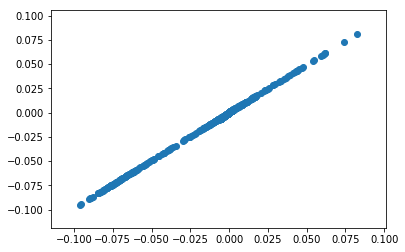

In [32]:
%matplotlib inline
plt.scatter(results[0][1][0.03651740006917935],GGL.fit_[-1]['beta'] )

In [33]:
    GGL2 = GradientGroupLasso(dg_M, df_M, np.asarray([0.03651740006917935]), reg_l2, 5000,learning_rate, tol, beta0_npm= results[0][1][0.03651740006917935])
    GGL2.fit()

0
6 1.5625
1
0 1.5625
2
0 1.5625
3
0 1.5625
4
0 1.5625
5
0 1.5625
6
0 1.5625
7
0 1.5625
8
0 1.5625
9
0 1.5625
10
0 1.5625
11
0 1.5625
12
0 1.5625
13
0 1.5625
14
0 1.5625
15
0 1.5625
16
0 1.5625
17
0 1.5625
18
0 1.5625
19
0 1.5625
20
0 1.5625
21
0 1.5625
22
0 1.5625
23
0 1.5625
24
0 1.5625
25
0 1.5625
26
0 1.5625
27
0 1.5625
28
0 1.5625
29
0 1.5625
30
0 1.5625
31
0 1.5625
32
0 1.5625
33
0 1.5625
34
0 1.5625
35
0 1.5625
36
0 1.5625
37
0 1.5625
38
0 1.5625
39
0 1.5625
40
0 1.5625
41
0 1.5625
42
0 1.5625
43
0 1.5625
44
0 1.5625
45
0 1.5625
46
0 1.5625
47
0 1.5625
48
0 1.5625
49
0 1.5625
50
0 1.5625
51
0 1.5625
52
0 1.5625
53
0 1.5625
54
0 1.5625
55
0 1.5625
56
0 1.5625
57
0 1.5625
58
0 1.5625
59
0 1.5625
60
0 1.5625
61
0 1.5625
62
0 1.5625
63
0 1.5625
64
0 1.5625
65
0 1.5625
66
0 1.5625
67
0 1.5625
68
0 1.5625
69
0 1.5625
70
0 1.5625
71
0 1.5625
72
0 1.5625
73
0 1.5625
74
0 1.5625
75
0 1.5625
76
0 1.5625
77
0 1.5625
78
0 1.5625
79
0 1.5625
80
0 1.5625
81
0 1.5625
82
0 1.5625
83
0 1.5625
84

0 1.5625
641
0 1.5625
642
0 1.5625
643
0 1.5625
644
0 1.5625
645
0 1.5625
646
0 1.5625
647
0 1.5625
648
0 1.5625
649
0 1.5625
650
0 1.5625
651
0 1.5625
652
0 1.5625
653
0 1.5625
654
0 1.5625
655
0 1.5625
656
0 1.5625
657
0 1.5625
658
0 1.5625
659
0 1.5625
660
0 1.5625
661
0 1.5625
662
0 1.5625
663
0 1.5625
664
0 1.5625
665
0 1.5625
666
0 1.5625
667
0 1.5625
668
0 1.5625
669
0 1.5625
670
0 1.5625
671
0 1.5625
672
0 1.5625
673
0 1.5625
674
0 1.5625
675
0 1.5625
676
0 1.5625
677
0 1.5625
678
0 1.5625
679
0 1.5625
680
0 1.5625
681
0 1.5625
682
0 1.5625
683
0 1.5625
684
0 1.5625
685
0 1.5625
686
0 1.5625
687
0 1.5625
688
0 1.5625
689
0 1.5625
690
0 1.5625
691
0 1.5625
692
0 1.5625
693
0 1.5625
694
0 1.5625
695
0 1.5625
696
0 1.5625
697
0 1.5625
698
0 1.5625
699
0 1.5625
700
0 1.5625
701
0 1.5625
702
0 1.5625
703
0 1.5625
704
0 1.5625
705
0 1.5625
706
0 1.5625
707
0 1.5625
708
0 1.5625
709
0 1.5625
710
0 1.5625
711
0 1.5625
712
0 1.5625
713
0 1.5625
714
0 1.5625
715
0 1.5625
716
0 1.5625
717

1253
0 1.5625
1254
0 1.5625
1255
0 1.5625
1256
0 1.5625
1257
0 1.5625
1258
0 1.5625
1259
0 1.5625
1260
0 1.5625
1261
0 1.5625
1262
0 1.5625
1263
0 1.5625
1264
0 1.5625
1265
0 1.5625
1266
0 1.5625
1267
0 1.5625
1268
0 1.5625
1269
0 1.5625
1270
0 1.5625
1271
0 1.5625
1272
0 1.5625
1273
0 1.5625
1274
0 1.5625
1275
0 1.5625
1276
0 1.5625
1277
0 1.5625
1278
0 1.5625
1279
0 1.5625
1280
0 1.5625
1281
0 1.5625
1282
0 1.5625
1283
0 1.5625
1284
0 1.5625
1285
0 1.5625
1286
0 1.5625
1287
0 1.5625
1288
0 1.5625
1289
0 1.5625
1290
0 1.5625
1291
0 1.5625
1292
0 1.5625
1293
0 1.5625
1294
0 1.5625
1295
0 1.5625
1296
0 1.5625
1297
0 1.5625
1298
0 1.5625
1299
0 1.5625
1300
0 1.5625
1301
0 1.5625
1302
0 1.5625
1303
0 1.5625
1304
0 1.5625
1305
0 1.5625
1306
0 1.5625
1307
0 1.5625
1308
0 1.5625
1309
0 1.5625
1310
0 1.5625
1311
0 1.5625
1312
0 1.5625
1313
0 1.5625
1314
0 1.5625
1315
0 1.5625
1316
0 1.5625
1317
0 1.5625
1318
0 1.5625
1319
0 1.5625
1320
0 1.5625
1321
0 1.5625
1322
0 1.5625
1323
0 1.5625
1324
0

1830
0 0.78125
1831
0 0.78125
1832
0 0.78125
1833
0 0.78125
1834
0 0.78125
1835
0 0.78125
1836
0 0.78125
1837
0 0.78125
1838
0 0.78125
1839
0 0.78125
1840
0 0.78125
1841
0 0.78125
1842
0 0.78125
1843
0 0.78125
1844
0 0.78125
1845
0 0.78125
1846
0 0.78125
1847
0 0.78125
1848
0 0.78125
1849
0 0.78125
1850
0 0.78125
1851
0 0.78125
1852
0 0.78125
1853
0 0.78125
1854
0 0.78125
1855
0 0.78125
1856
0 0.78125
1857
0 0.78125
1858
0 0.78125
1859
0 0.78125
1860
0 0.78125
1861
0 0.78125
1862
0 0.78125
1863
0 0.78125
1864
0 0.78125
1865
0 0.78125
1866
0 0.78125
1867
0 0.78125
1868
0 0.78125
1869
0 0.78125
1870
0 0.78125
1871
0 0.78125
1872
0 0.78125
1873
0 0.78125
1874
0 0.78125
1875
0 0.78125
1876
0 0.78125
1877
0 0.78125
1878
0 0.78125
1879
0 0.78125
1880
0 0.78125
1881
0 0.78125
1882
0 0.78125
1883
0 0.78125
1884
0 0.78125
1885
0 0.78125
1886
0 0.78125
1887
0 0.78125
1888
0 0.78125
1889
0 0.78125
1890
0 0.78125
1891
0 0.78125
1892
0 0.78125
1893
0 0.78125
1894
0 0.78125
1895
0 0.78125
1896
0 0.7

0 0.78125
2378
0 0.78125
2379
0 0.78125
2380
0 0.78125
2381
0 0.78125
2382
0 0.78125
2383
0 0.78125
2384
0 0.78125
2385
0 0.78125
2386
0 0.78125
2387
0 0.78125
2388
0 0.78125
2389
0 0.78125
2390
0 0.78125
2391
0 0.78125
2392
0 0.78125
2393
0 0.78125
2394
0 0.78125
2395
0 0.78125
2396
0 0.78125
2397
0 0.78125
2398
0 0.78125
2399
0 0.78125
2400
0 0.78125
2401
0 0.78125
2402
0 0.78125
2403
0 0.78125
2404
0 0.78125
2405
0 0.78125
2406
0 0.78125
2407
0 0.78125
2408
0 0.78125
2409
0 0.78125
2410
0 0.78125
2411
0 0.78125
2412
0 0.78125
2413
0 0.78125
2414
0 0.78125
2415
0 0.78125
2416
0 0.78125
2417
0 0.78125
2418
0 0.78125
2419
0 0.78125
2420
0 0.78125
2421
0 0.78125
2422
0 0.78125
2423
0 0.78125
2424
0 0.78125
2425
0 0.78125
2426
0 0.78125
2427
0 0.78125
2428
0 0.78125
2429
0 0.78125
2430
0 0.78125
2431
0 0.78125
2432
0 0.78125
2433
0 0.78125
2434
0 0.78125
2435
0 0.78125
2436
0 0.78125
2437
0 0.78125
2438
0 0.78125
2439
0 0.78125
2440
0 0.78125
2441
0 0.78125
2442
0 0.78125
2443
0 0.78125


2909
0 4.6566128730773926e-08
2910
0 4.6566128730773926e-08
2911
0 4.6566128730773926e-08
2912
0 4.6566128730773926e-08
2913
0 4.6566128730773926e-08
2914
0 4.6566128730773926e-08
2915
0 4.6566128730773926e-08
2916
0 4.6566128730773926e-08
2917
0 4.6566128730773926e-08
2918
0 4.6566128730773926e-08
2919
0 4.6566128730773926e-08
2920
0 4.6566128730773926e-08
2921
0 4.6566128730773926e-08
2922
0 4.6566128730773926e-08
2923
0 4.6566128730773926e-08
2924
0 4.6566128730773926e-08
2925
0 4.6566128730773926e-08
2926
0 4.6566128730773926e-08
2927
0 4.6566128730773926e-08
2928
0 4.6566128730773926e-08
2929
0 4.6566128730773926e-08
2930
0 4.6566128730773926e-08
2931
0 4.6566128730773926e-08
2932
0 4.6566128730773926e-08
2933
0 4.6566128730773926e-08
2934
0 4.6566128730773926e-08
2935
0 4.6566128730773926e-08
2936
0 4.6566128730773926e-08
2937
2 1.1641532182693481e-08
2938
0 1.1641532182693481e-08
2939
0 1.1641532182693481e-08
2940
0 1.1641532182693481e-08
2941
0 1.1641532182693481e-08
2942
0 1.1

3186
0 1.1368683772161603e-11
3187
0 1.1368683772161603e-11
3188
0 1.1368683772161603e-11
3189
0 1.1368683772161603e-11
3190
0 1.1368683772161603e-11
3191
0 1.1368683772161603e-11
3192
0 1.1368683772161603e-11
3193
0 1.1368683772161603e-11
3194
0 1.1368683772161603e-11
3195
0 1.1368683772161603e-11
3196
0 1.1368683772161603e-11
3197
0 1.1368683772161603e-11
3198
0 1.1368683772161603e-11
3199
0 1.1368683772161603e-11
3200
0 1.1368683772161603e-11
3201
0 1.1368683772161603e-11
3202
0 1.1368683772161603e-11
3203
0 1.1368683772161603e-11
3204
0 1.1368683772161603e-11
3205
0 1.1368683772161603e-11
3206
0 1.1368683772161603e-11
3207
0 1.1368683772161603e-11
3208
0 1.1368683772161603e-11
3209
0 1.1368683772161603e-11
3210
0 1.1368683772161603e-11
3211
0 1.1368683772161603e-11
3212
0 1.1368683772161603e-11
3213
0 1.1368683772161603e-11
3214
0 1.1368683772161603e-11
3215
0 1.1368683772161603e-11
3216
0 1.1368683772161603e-11
3217
0 1.1368683772161603e-11
3218
0 1.1368683772161603e-11
3219
0 1.1

3464
0 3.552713678800501e-13
3465
0 3.552713678800501e-13
3466
0 3.552713678800501e-13
3467
0 3.552713678800501e-13
3468
0 3.552713678800501e-13
3469
0 3.552713678800501e-13
3470
0 3.552713678800501e-13
3471
0 3.552713678800501e-13
3472
0 3.552713678800501e-13
3473
0 3.552713678800501e-13
3474
0 3.552713678800501e-13
3475
0 3.552713678800501e-13
3476
0 3.552713678800501e-13
3477
0 3.552713678800501e-13
3478
0 3.552713678800501e-13
3479
0 3.552713678800501e-13
3480
0 3.552713678800501e-13
3481
0 3.552713678800501e-13
3482
0 3.552713678800501e-13
3483
0 3.552713678800501e-13
3484
0 3.552713678800501e-13
3485
0 3.552713678800501e-13
3486
0 3.552713678800501e-13
3487
0 3.552713678800501e-13
3488
0 3.552713678800501e-13
3489
0 3.552713678800501e-13
3490
0 3.552713678800501e-13
3491
0 3.552713678800501e-13
3492
0 3.552713678800501e-13
3493
0 3.552713678800501e-13
3494
0 3.552713678800501e-13
3495
0 3.552713678800501e-13
3496
0 3.552713678800501e-13
3497
0 3.552713678800501e-13
3498
0 3.55271

3748
0 3.552713678800501e-13
3749
0 3.552713678800501e-13
3750
0 3.552713678800501e-13
3751
0 3.552713678800501e-13
3752
0 3.552713678800501e-13
3753
0 3.552713678800501e-13
3754
0 3.552713678800501e-13
3755
0 3.552713678800501e-13
3756
0 3.552713678800501e-13
3757
0 3.552713678800501e-13
3758
0 3.552713678800501e-13
3759
0 3.552713678800501e-13
3760
0 3.552713678800501e-13
3761
0 3.552713678800501e-13
3762
0 3.552713678800501e-13
3763
0 3.552713678800501e-13
3764
0 3.552713678800501e-13
3765
0 3.552713678800501e-13
3766
0 3.552713678800501e-13
3767
0 3.552713678800501e-13
3768
0 3.552713678800501e-13
3769
0 3.552713678800501e-13
3770
0 3.552713678800501e-13
3771
0 3.552713678800501e-13
3772
0 3.552713678800501e-13
3773
0 3.552713678800501e-13
3774
0 3.552713678800501e-13
3775
0 3.552713678800501e-13
3776
0 3.552713678800501e-13
3777
0 3.552713678800501e-13
3778
0 3.552713678800501e-13
3779
0 3.552713678800501e-13
3780
0 3.552713678800501e-13
3781
0 3.552713678800501e-13
3782
0 3.55271

4031
0 3.552713678800501e-13
4032
0 3.552713678800501e-13
4033
0 3.552713678800501e-13
4034
0 3.552713678800501e-13
4035
0 3.552713678800501e-13
4036
0 3.552713678800501e-13
4037
0 3.552713678800501e-13
4038
0 3.552713678800501e-13
4039
0 3.552713678800501e-13
4040
0 3.552713678800501e-13
4041
0 3.552713678800501e-13
4042
0 3.552713678800501e-13
4043
0 3.552713678800501e-13
4044
0 3.552713678800501e-13
4045
0 3.552713678800501e-13
4046
0 3.552713678800501e-13
4047
0 3.552713678800501e-13
4048
0 3.552713678800501e-13
4049
0 3.552713678800501e-13
4050
0 3.552713678800501e-13
4051
0 3.552713678800501e-13
4052
0 3.552713678800501e-13
4053
0 3.552713678800501e-13
4054
0 3.552713678800501e-13
4055
0 3.552713678800501e-13
4056
0 3.552713678800501e-13
4057
0 3.552713678800501e-13
4058
0 3.552713678800501e-13
4059
0 3.552713678800501e-13
4060
0 3.552713678800501e-13
4061
0 3.552713678800501e-13
4062
0 3.552713678800501e-13
4063
0 3.552713678800501e-13
4064
0 3.552713678800501e-13
4065
0 3.55271

4310
0 1.7763568394002505e-13
4311
0 1.7763568394002505e-13
4312
0 1.7763568394002505e-13
4313
0 1.7763568394002505e-13
4314
0 1.7763568394002505e-13
4315
0 1.7763568394002505e-13
4316
0 1.7763568394002505e-13
4317
0 1.7763568394002505e-13
4318
0 1.7763568394002505e-13
4319
0 1.7763568394002505e-13
4320
0 1.7763568394002505e-13
4321
0 1.7763568394002505e-13
4322
0 1.7763568394002505e-13
4323
0 1.7763568394002505e-13
4324
0 1.7763568394002505e-13
4325
0 1.7763568394002505e-13
4326
0 1.7763568394002505e-13
4327
0 1.7763568394002505e-13
4328
0 1.7763568394002505e-13
4329
0 1.7763568394002505e-13
4330
0 1.7763568394002505e-13
4331
0 1.7763568394002505e-13
4332
0 1.7763568394002505e-13
4333
0 1.7763568394002505e-13
4334
0 1.7763568394002505e-13
4335
0 1.7763568394002505e-13
4336
0 1.7763568394002505e-13
4337
0 1.7763568394002505e-13
4338
0 1.7763568394002505e-13
4339
0 1.7763568394002505e-13
4340
0 1.7763568394002505e-13
4341
0 1.7763568394002505e-13
4342
0 1.7763568394002505e-13
4343
0 1.7

4585
0 1.7763568394002505e-13
4586
0 1.7763568394002505e-13
4587
0 1.7763568394002505e-13
4588
0 1.7763568394002505e-13
4589
0 1.7763568394002505e-13
4590
0 1.7763568394002505e-13
4591
0 1.7763568394002505e-13
4592
0 1.7763568394002505e-13
4593
0 1.7763568394002505e-13
4594
0 1.7763568394002505e-13
4595
0 1.7763568394002505e-13
4596
0 1.7763568394002505e-13
4597
0 1.7763568394002505e-13
4598
0 1.7763568394002505e-13
4599
0 1.7763568394002505e-13
4600
0 1.7763568394002505e-13
4601
0 1.7763568394002505e-13
4602
0 1.7763568394002505e-13
4603
0 1.7763568394002505e-13
4604
0 1.7763568394002505e-13
4605
0 1.7763568394002505e-13
4606
0 1.7763568394002505e-13
4607
0 1.7763568394002505e-13
4608
0 1.7763568394002505e-13
4609
0 1.7763568394002505e-13
4610
0 1.7763568394002505e-13
4611
0 1.7763568394002505e-13
4612
0 1.7763568394002505e-13
4613
0 1.7763568394002505e-13
4614
0 1.7763568394002505e-13
4615
0 1.7763568394002505e-13
4616
0 1.7763568394002505e-13
4617
0 1.7763568394002505e-13
4618
0 1.7

4860
0 1.7763568394002505e-13
4861
0 1.7763568394002505e-13
4862
0 1.7763568394002505e-13
4863
0 1.7763568394002505e-13
4864
0 1.7763568394002505e-13
4865
0 1.7763568394002505e-13
4866
0 1.7763568394002505e-13
4867
0 1.7763568394002505e-13
4868
0 1.7763568394002505e-13
4869
0 1.7763568394002505e-13
4870
0 1.7763568394002505e-13
4871
0 1.7763568394002505e-13
4872
0 1.7763568394002505e-13
4873
0 1.7763568394002505e-13
4874
0 1.7763568394002505e-13
4875
0 1.7763568394002505e-13
4876
0 1.7763568394002505e-13
4877
0 1.7763568394002505e-13
4878
0 1.7763568394002505e-13
4879
0 1.7763568394002505e-13
4880
0 1.7763568394002505e-13
4881
0 1.7763568394002505e-13
4882
0 1.7763568394002505e-13
4883
0 1.7763568394002505e-13
4884
0 1.7763568394002505e-13
4885
0 1.7763568394002505e-13
4886
0 1.7763568394002505e-13
4887
0 1.7763568394002505e-13
4888
0 1.7763568394002505e-13
4889
0 1.7763568394002505e-13
4890
0 1.7763568394002505e-13
4891
0 1.7763568394002505e-13
4892
0 1.7763568394002505e-13
4893
0 1.7

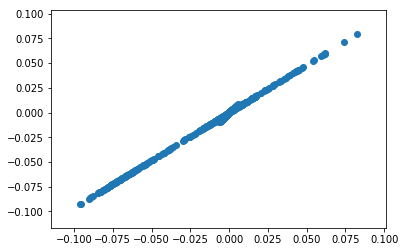

In [34]:
%matplotlib inline
plt.scatter(results[0][1][0.03651740006917935],GGL2.fit_[-1]['beta'] )

/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


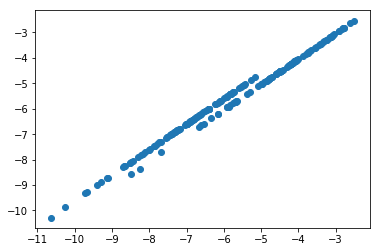

In [43]:
%matplotlib inline
plt.scatter(np.log(results[0][1][0.03651740006917935]),np.log(GGL2.fit_[-1]['beta'] ))

In [42]:
GGL2.lossresults[0.03651740006917935][-10:]

[0.14949291763850747,
 0.14949291769988382,
 0.1494929177612357,
 0.14949291782256313,
 0.14949291788386618,
 0.1494929179451448,
 0.14949291800639902,
 0.14949291806762877,
 0.14949291812883422,
 0.14949291819001526]

In [37]:
np.where(GGL2.fit_[-1]['beta'] !=0)[0].shape

(600,)

In [39]:
GGL.lossresults

{0.03651740006917935: [0.15445599843260022,
  0.15053245542315014,
  0.15006958319838,
  0.14992044419456485,
  0.14980720365878686,
  0.14974451214502243,
  0.1497166197088687,
  0.1496976633864897,
  0.14968379757135633,
  0.149673598956396,
  0.14966463589599224,
  0.14965584397248982,
  0.14964809125817738,
  0.14964267915361218,
  0.14963752407495035,
  0.14963321406501054,
  0.14962965361177777,
  0.1496266109348709,
  0.14962344183460669,
  0.1496201437669176,
  0.14961677673643375,
  0.14961333579795769,
  0.14961034096115178,
  0.1496073206040166,
  0.14960494348218942,
  0.14960251732417384,
  0.1495999389740311,
  0.14959726054166203,
  0.14959452824291783,
  0.14959174129295397,
  0.14958905932072183,
  0.14958636758077762,
  0.1495836587958035,
  0.14958105124418253,
  0.14957909288541388,
  0.1495774005733403,
  0.1495756124370943,
  0.14957401106061877,
  0.14957225343322456,
  0.14957044773593073,
  0.149568689380637,
  0.1495671774384851,
  0.14956563181357166,
  0.149

In [45]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()

In [46]:
print(datetime.now())

2020-12-02 18:21:20.846072
